# Modeling Fuel Efficiency: A Comparative Analysis of Distributional and Linear Regression Approaches on the Auto-MPG Dataset

In this analysis, the Auto-MPG dataset from StatLib is used to model automobile fuel efficiency (mpg) of various automobiles. The workflow includes ETL, exploratory data analysis (EDA), and data transformations to improve model performance and interpretability. Two models are explored: a Gaussian distributional model and a linear regression model. The linear regression model is evaluated using three rounds of 10-fold cross-validation, with $R^2$ and $\sigma$ estimates, and 95% Bootstrap credible intervals are computed to assess prediction reliability. Learning curves reveal whether additional data would or would not significantly improve model performance. Predictions from the null, distributional, and linear regression models are compared to provide a comprehensive understanding of the approaches.

<a id="contents"></a>
# Content

1. [ETL](#step1)
2. [EDA](#step2)
   - [mpg](#step3)
   - [cylinders](#step4)
   - [displacement](#step5)
   - [horsepower](#step6)
   - [weight](#step7)
   - [acceleration](#step8)
   - [model year](#step9)
   - [origin](#step10)
3. [Pairwise EDA](#step11)
   - [mpg vs. cylinders](#step12)
   - [mpg vs. displacement](#step13)
   - [mpg vs. horsepower](#step14)
   - [mpg vs. weight](#step15)
   - [mpg vs. model year](#step16)
4. [Digging Deeper](#step17)
5. [Null & Distributional Models](#step18)
    - [Null Model](#step19)
    - [Distributional Model](#step20)
    - [Null Model Prediction](#step21)
    - [Distributional Model Predictions](#step22)
6. [Build Linear Regression Model](#step23)
   - [Model Evaluation](#step24)
   - [Learning Curve](#step25)
7. [Final Model](#step26)
8. [Use Model](#step27)
    - [Null Model Prediction](#step28)
    - [Linear Regression Predictions](#step29)
9. [Conclusion](#step30)

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import requests
import re
from pandas.core.algorithms import value_counts
from pandas.core.reshape.concat import concat
from scipy.stats import lognorm
import random
import patsy

sns.set(style="whitegrid")

# You may load the dataset from URL (instead of the local file) if you wish
auto_mpg_data = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.data.txt"
auto_mpg_names = "https://raw.githubusercontent.com/fundamentals-of-data-science/datasets/master/auto-mpg.names.txt"

data = requests.get(auto_mpg_data).text
names = requests.get(auto_mpg_names).text

## <a id="step1">(ETL) Extract, Transform, Load the Data</a>
<a href="#contents">^ Contents</a>

Let's begin the ETL with looking at the details of this dataset:

In [7]:
print(names)

1. Title: Auto-Mpg Data

2. Sources:
   (a) Origin:  This dataset was taken from the StatLib library which is
                maintained at Carnegie Mellon University. The dataset was 
                used in the 1983 American Statistical Association Exposition.
   (c) Date: July 7, 1993

3. Past Usage:
    -  See 2b (above)
    -  Quinlan,R. (1993). Combining Instance-Based and Model-Based Learning.
       In Proceedings on the Tenth International Conference of Machine 
       Learning, 236-243, University of Massachusetts, Amherst. Morgan
       Kaufmann.

4. Relevant Information:

   This dataset is a slightly modified version of the dataset provided in
   the StatLib library.  In line with the use by Ross Quinlan (1993) in
   predicting the attribute "mpg", 8 of the original instances were removed 
   because they had unknown values for the "mpg" attribute.  The original 
   dataset is available in the file "auto-mpg.data-original".

   "The data concerns city-cycle fuel consumptio

This dataset has 8 features that are numerical variables: mpg, cylinders, displacement, horsepower, weight, acceleration, model year, and origin. The last feature 'car name' are strings that have unique instances. This dataset features aren't labeled so let's store the data into a DataFrame with their corresponding column names:

In [9]:
column_names = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year', 'origin', 'car name']

# Split data into lines
data_lines = data.strip().split('\n')

# Define regular expression pattern to split data
pattern = r'(".*?"|\S+)'

# Split each line using regular expression pattern
data_values = [re.findall(pattern, line) for line in data_lines]

df = pd.DataFrame(data_values, columns=column_names)

display(df.head())

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car name
0,18.0,8,307.0,130.0,3504.,12.0,70,1,"""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693.,11.5,70,1,"""buick skylark 320"""
2,18.0,8,318.0,150.0,3436.,11.0,70,1,"""plymouth satellite"""
3,16.0,8,304.0,150.0,3433.,12.0,70,1,"""amc rebel sst"""
4,17.0,8,302.0,140.0,3449.,10.5,70,1,"""ford torino"""


According to the auto_mpg 'names' above, it's stated that 'horsepower' has 6 missing values. The missing values are in the data as '?', so I will need to convert it to NaN values.

In [11]:
question_mark_indices = np.where(df.values == '?')

df.replace('?', np.nan, inplace=True)

Let's look at the info() of the data and to make sure we have 6 missing values in 'horsepower':

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   mpg           398 non-null    object
 1   cylinders     398 non-null    object
 2   displacement  398 non-null    object
 3   horsepower    392 non-null    object
 4   weight        398 non-null    object
 5   acceleration  398 non-null    object
 6   model_year    398 non-null    object
 7   origin        398 non-null    object
 8   car name      398 non-null    object
dtypes: object(9)
memory usage: 28.1+ KB


During the conversion to a DataFrame, all features were created as objects. Let's convert the numerical features back to numerical variables.

In [15]:
df['mpg'] = pd.to_numeric(df['mpg'])
df['cylinders'] = pd.to_numeric(df['cylinders'])
df['displacement'] = pd.to_numeric(df['displacement'])
df['horsepower'] = pd.to_numeric(df['horsepower'])
df['weight'] = pd.to_numeric(df['weight'])
df['acceleration'] = pd.to_numeric(df['acceleration'])
df['model_year'] = pd.to_numeric(df['model_year'])
df['origin'] = pd.to_numeric(df['origin'])

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model_year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


## <a id="step2">(EDA) Exploratory Data Analysis</a>
<a href="#contents">^ Contents</a>

Let's begin the EDA with single variable exploration. I will not be using the 'car name' feature for this analysis since each observations are unique for this dataset.

### 1. <a id="step3"> mpg</a>
<a href="#contents">^ Contents</a>

According to the [Federal Highway Administration](https://www.fhwa.dot.gov/ohim/onh00/onh2p8.htm#:~:text=Indices%20for%20vehicle%2Dmiles%20of,2000%2C%20a%2029.0%25%20increase.), average fuel economy (miles per gallon) for all vehicles were 12.0 miles per gallon in 1970. In response to the old price shock in the early 1970s, in 1975 Congress passed the nation's first [Corporate Average Fuel Economy (CAFE)](https://www.pewtrusts.org/en/research-and-analysis/fact-sheets/2011/04/20/driving-to-545-mpg-the-history-of-fuel-economy) standards. The law mandated the doubling of vehicle fuel efficiency to 27.5 mpg within 10 years. Therefore, in the early 1980s the fuel efficiency steadily increased as you can see in the image below:

![Fuel Economy](https://www.pewtrusts.org/-/media/legacy/uploadedimages/peg/publications/fact_sheet/clenfueleconomychart650jpg.jpg)

I expect the average of this dataset to be 24 mpg since this dataset have vehicles from the 70s and 80s. Let's look at the summary descriptive of 'mpg':

In [21]:
df.mpg.describe()

count    398.000000
mean      23.514573
std        7.815984
min        9.000000
25%       17.500000
50%       23.000000
75%       29.000000
max       46.600000
Name: mpg, dtype: float64

The average of this data is 23.5 mpg. I was pretty close with my prediction. The range is from 9 to 46.6, which is pretty wide. Standard deviation of 7.8 is a little high for this range. The median (23) is slightly smaller than the mean (23.51), so I expect this data to be slightly skewed to the right, but not much. Let's visualize the spread of the data using the helper functions from the Fundamentals and plot a histogram with a box-and-whiskers plot using the Freedman's Diaconis Rule to determine the best bin sizes for the distribution:

In [23]:
def freedman_diaconis(data):
    quartiles = stats.mstats.mquantiles( data, [0.25, 0.5, 0.75])
    iqr = quartiles[2] - quartiles[ 0]
    n = len( data)
    h = 2.0 * (iqr/n**(1.0/3.0))
    return int( h)

In [24]:
def histogram_w_whiskers(data, variable_name, zoom=None):
    h = freedman_diaconis(data[variable_name])
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freedman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()
        
    # start the plot: 2 rows, because we want the boxplot on the first row
    # and the hist on the second
    fig, ax = plt.subplots(
        2, figsize=(7, 5), sharex=True,
        gridspec_kw={"height_ratios": (.7, .3)}  # the boxplot gets 30% of the vertical space
    )

    # the histogram
    ax[0].hist(data[variable_name],bins=bins, color="dimgray", weights=empirical_weights)
    ax[0].set_title(f"{variable_name} distribution - Freedman Diaconis")
    ax[0].set_ylabel("Relative Frequency")
    if zoom:
        ax[0].set_ylim((0, zoom))
    # the box plot
    ax[1].boxplot(data[variable_name], vert=False)
    # removing borders
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xlabel(variable_name)

    # and we are good to go
    plt.show()
    plt.close()
    # return h

Freedman Diaconis for mpg: 13 bins


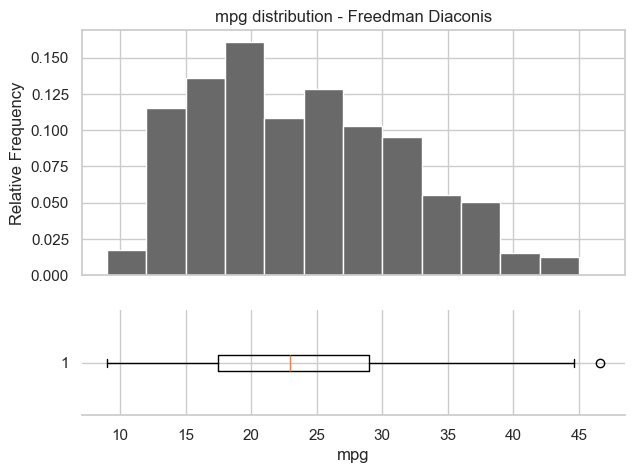

In [25]:
histogram_w_whiskers(df, 'mpg')

The spread of the data is a lot more right skewed than I thought. The box-and-whiskers plot indicates that there is a possible outlier in this distribution. The distribution looks like there is two bumps, thus indicating that it is multimodal. Let's plot the histograms with half as many and twice as many bins to help with the signal and noise:

In [27]:
def histogram_trio(data, variable_name, zoom=1.0):
    h = freedman_diaconis(data[variable_name])
    if h == 0:
        h = 1
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range( mn, mx, h)]
    print(f"Freedman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations)/observations # this converts counts to relative frequencies when used in hist()

    fig, ax = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    fewer_bins = int(len(bins) * .50)
    more_bins = int(len(bins) * 2)

    n, bins, patches = ax[1].hist(data[variable_name], color="DimGray", bins=bins, weights=empirical_weights) # <---
    # ax[1].grid()
    ax[1].set_xlabel(variable_name)
    ax[1].set_ylabel("Relative Frequency")
    ax[1].set_title(f"Relative Frequency Histogram of {variable_name}")
    ax[1].set_ylim((0, zoom))
    
    n, bins, patches = ax[0].hist(data[variable_name], color="DimGray", bins=fewer_bins, weights=empirical_weights)
    # ax[0].grid()
    ax[0].set_xlabel(variable_name)
    ax[0].set_ylabel("Relative Frequency")
    ax[0].set_title(f"Relative Frequency Histogram of {variable_name} (Fewer Bins)")
    
    n, bins, patches = ax[2].hist(data[variable_name], color="DimGray", bins=more_bins, weights=empirical_weights)
    # ax[2].grid()
    ax[2].set_xlabel(variable_name)
    ax[2].set_ylabel("Relative Frequency")
    ax[2].set_title(f"Relative Frequency Histogram of {variable_name} (More Bins)")

    plt.show()
    plt.close()

Freedman Diaconis for mpg: 13 bins


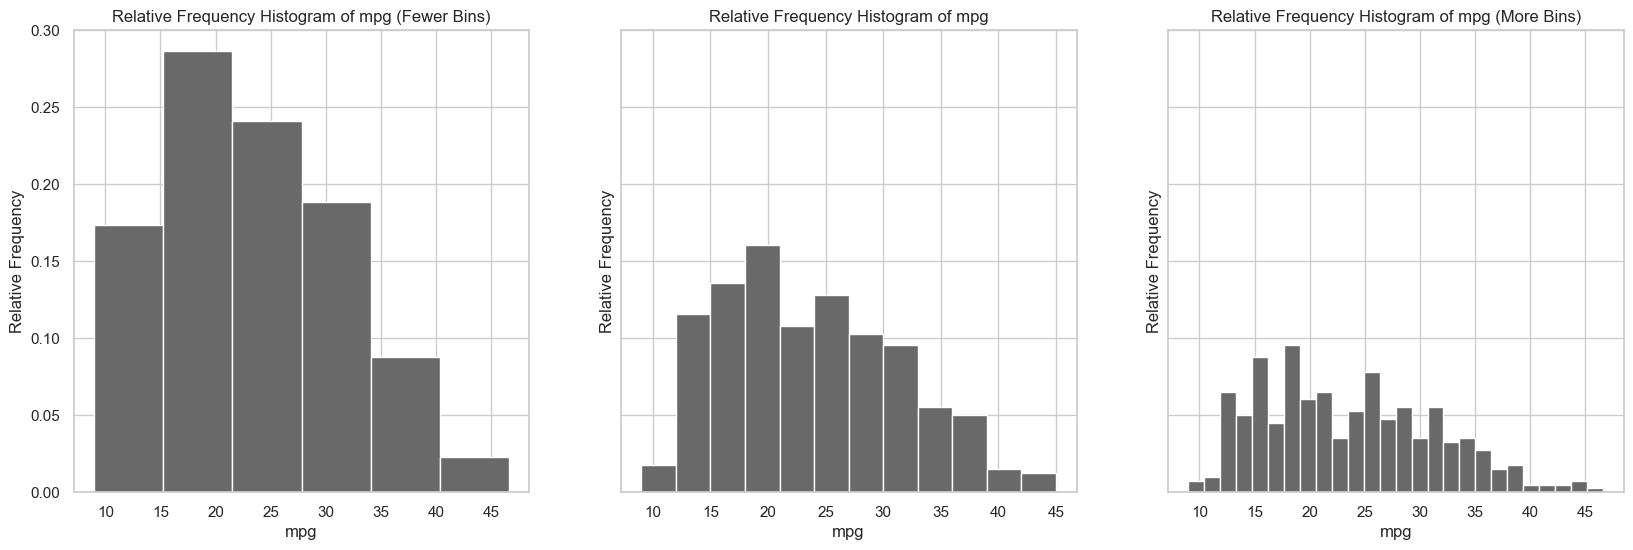

In [28]:
histogram_trio(df, 'mpg', zoom=0.3)

Having half the amount of bins actually generalized the distribution too much. With more bins used the distribution is a lot more noisy and the shape of the distribution is very similar to the middle plot. The quesions that I have are:
1. I'm curious if cars (not trucks) were the most frequent vehicle type for the highest peak at around 18 mpg.
2. Does certain type of vehicles have the higher mpg of 40 or more?
3. Are certain type of cars grouped by the range of mpg?

### 2. <a id="step4"> cylinders</a>
<a href="#contents">^ Contents</a>

According to [Kia](https://www.kia.com/dm/discover-kia/ask/what-is-a-cylinder-in-a-car.html), the most cars have either four, six, or eight cylinders. The [most common](https://www.uti.edu/blog/automotive/engine-types) engine configuration is four cyclinders for small to midrange vehicles. High end performance and sports cars have increased number of cyclinders, like six or eight-cylinder engines. I would expect four cyclinders to be the most frequent number of cyclinders found in this data. Let's look at its descriptive statistics:

In [32]:
df.cylinders.describe()

count    398.000000
mean       5.454774
std        1.701004
min        3.000000
25%        4.000000
50%        4.000000
75%        8.000000
max        8.000000
Name: cylinders, dtype: float64

The smallest number of cylinders is 3, which was unexpected. The maximum is 8 cylinders. The mean (5.45) is larger than the median (4), so this indicates the distribution is right skewed. For a range of 5 the standard deviation of 1.7 is high. Let's graph the histogram with the box-and-whiskers plot:

Freedman Diaconis for cylinders: 5 bins


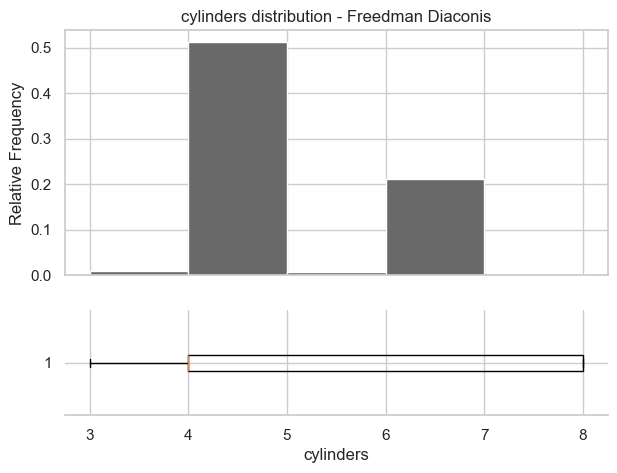

In [34]:
histogram_w_whiskers(df, 'cylinders')

The box-and-whiskers plot indicates that there is no extreme values in the data. This histogram is not a good representation of the data. In some ways the data is categorical as whole number representations, but we are going to treat it as numerical variable. Let's see if the distribution gets better with half or double the amount of bins:

Freedman Diaconis for cylinders: 5 bins


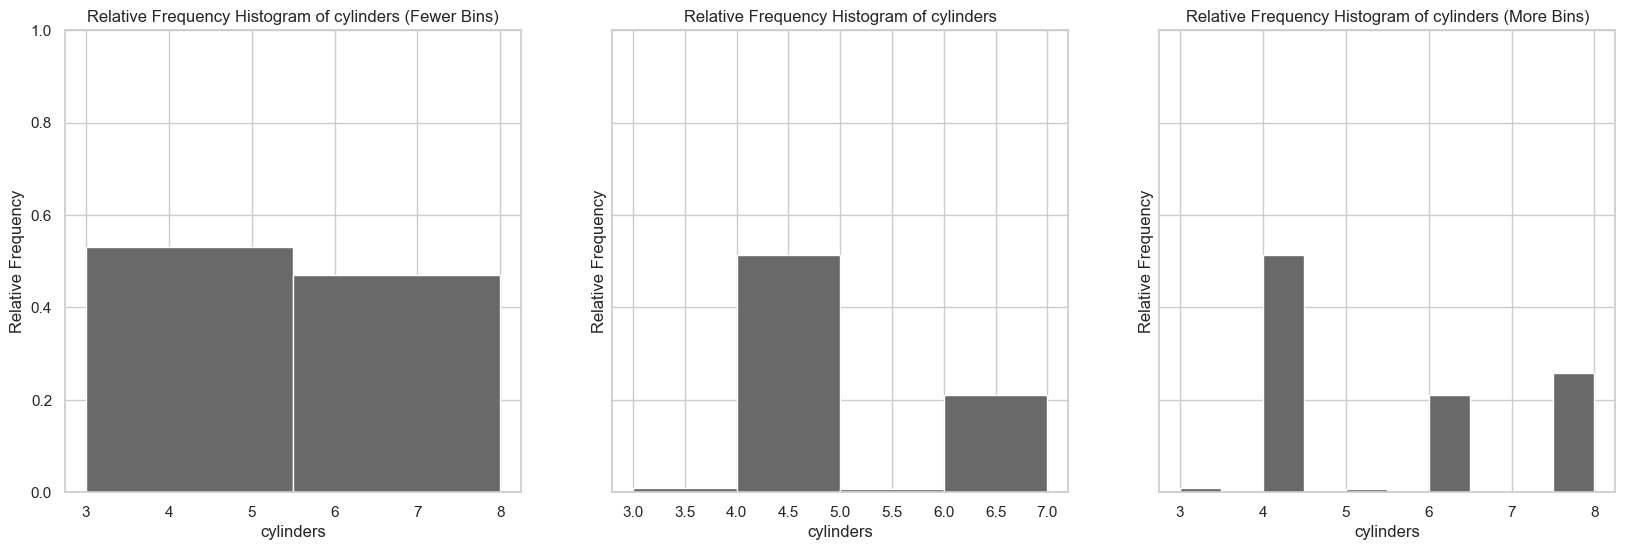

In [36]:
histogram_trio(df, 'cylinders')

Using less bins is obviously not a good choice as you can see in the left plot. It generalizes and groups the data too much and can't see the distribution very well. The plot with the double the amount of bins shows a good representation of the data. You can see that the various number of cylinders are 3, 4, 5, 6, and 8. We do not have a lot of data for vehicles with 3 or 5 cylinders. The most common number of cylinders is 4 cylinders, which was expected. Some questions that come up are:
1. Do the vehicles with 4 cylinders have a certain range of mpg in common with each other?
2. Do vehicles with 8 cylinders have lower mpg than vehicles with 4 cylinders?
3. Do vehicles with 6 cylinders get better mpg than vehicles with 8 cylinders?

### 3. <a id="step5"> displacement</a>
<a href="#contents">^ Contents</a>

According the [CarParts.com](https://www.carparts.com/blog/how-important-is-engine-displacement/), engine displacement is the total volume of the cylinders swept by the pistons during a stroke, measured in cubic centimeters (cc), cubic inches, or liters. It’s the maximum amount of air the engine can displace and is used to describe the size of the engine. Since we are in the United States, I assume the measurements for this data will be in cubin inches (cu in). A [4-cylinder engine](https://en.wikipedia.org/wiki/Straight-four_engine#:~:text=Most%20modern%20straight%2Dfour%20engines,92%E2%80%93153%20cu%20in) has a typical displacement of 79-153 cu in while an [8-cylinder engine](https://en.wikipedia.org/wiki/V8_engine#:~:text=The%20displacement%20of%20modern%20V8,214%20to%20391%20cu%20in) has a typical displacement of 214-391 cu in. I expect the range to be around 70-400 cu in. Let's look at the feature's descriptive statistics:

In [40]:
df.displacement.describe()

count    398.000000
mean     193.425879
std      104.269838
min       68.000000
25%      104.250000
50%      148.500000
75%      262.000000
max      455.000000
Name: displacement, dtype: float64

The range is from 68 to 455. This is very close to my prediction. The median (148.5) is smaller than the mean (193.4), which indicates that the distribution is right skewed. The standard deviation of 104.3 is high for this range of data. Let's graph the distribution with the histogram and box-and-whickers plot:

Freedman Diaconis for displacement: 9 bins


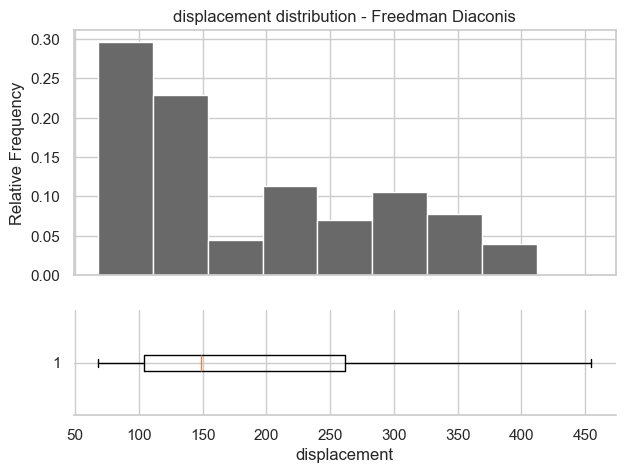

In [42]:
histogram_w_whiskers(df, 'displacement')

The histogram shows that the most common displacement size is between 68-150 cu in. The shape of the distribution shows that it's multimodal, one group between 68-150 cu in and the second group between 150-455 cu in. There is no indication of extreme values from the box-and-whiskers plot. Let's see if changing the bin sizes changes or keeps the same shape of the distribution:

Freedman Diaconis for displacement: 9 bins


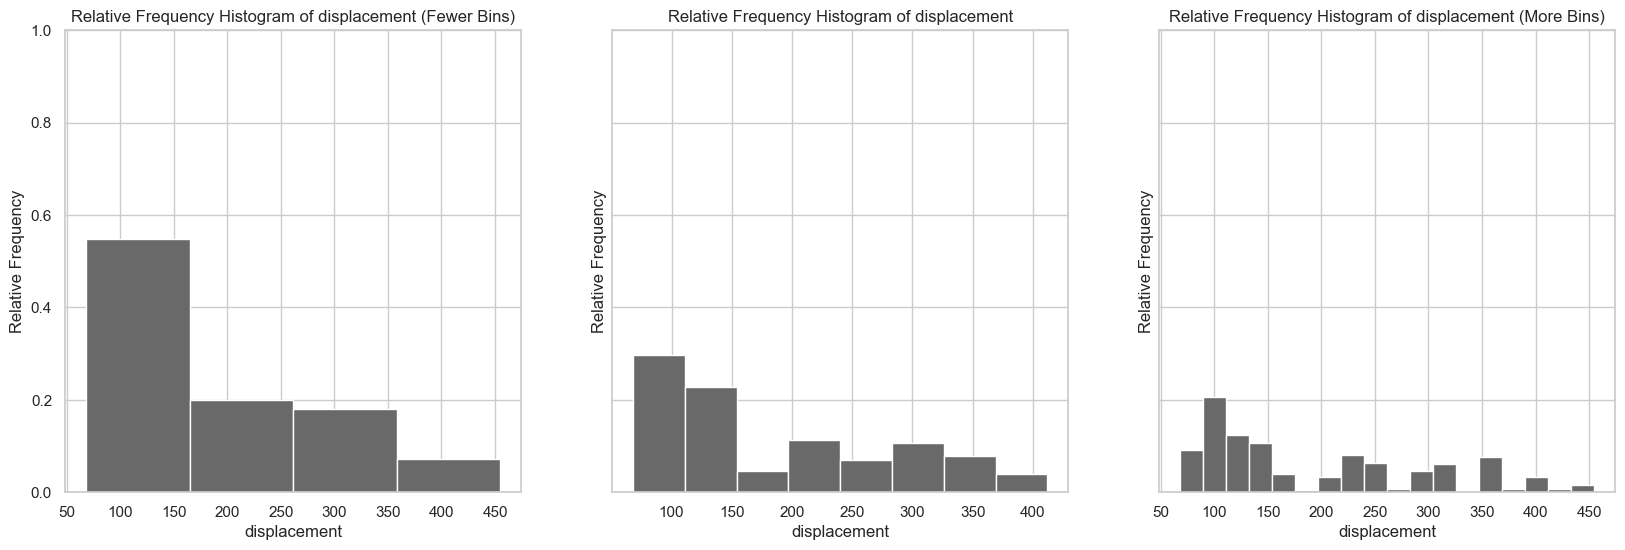

In [44]:
histogram_trio(df, 'displacement')

Using less bins is not practical. It generalizes the distribution too much. When more bins are used, you see a good separation of a group between 68 to about 175. The questions I have are:
1. Is the lowest group of displacement values are vehicles with 3 and 4 cylinder engines?
2. Does 6 and 8 cylinder engines have displacement between 200-455 cu in?
3. Does the lowest group of displacement values have higher mpg?

### 4. <a id="step6"> horsepower</a>
<a href="#contents">^ Contents</a>

[Horsepwer](https://www.kia.com/mu/discover-kia/ask/what-is-the-horsepower-in-a-car.html#:~:text=Horsepower%20is%20a%20measurement%20used%20to%20calculate%20how%20quickly%20the,the%20vehicle's%20maximum%20running%20capacity.) is a measurement of how fast a car's engine can work. In the 1970s the [average horse power](https://carbuzz.com/features/average-horsepower-of-a-car-over-the-years/) for a car was around 96 hp. A car's average horsepower went from 100 hp in 1980 to 120 hp in 1989. Since this data included vehicles with 8 cylinder engines, I assume that the maximum horsepower for this data is much greater than 120 hp. Let's look at the descriptive statistics:

In [48]:
df.horsepower.describe()

count    392.000000
mean     104.469388
std       38.491160
min       46.000000
25%       75.000000
50%       93.500000
75%      126.000000
max      230.000000
Name: horsepower, dtype: float64

The minimum horsepower is 46 hp and the maximum horsepower is 230 hp. The median (93.5) is smaller than the mean (104.5), which indicates that the distribution is right skewed. Let's plot the histogram with box-and-whiskers plot to visualize the distribution:

Freedman Diaconis for horsepower: 14 bins


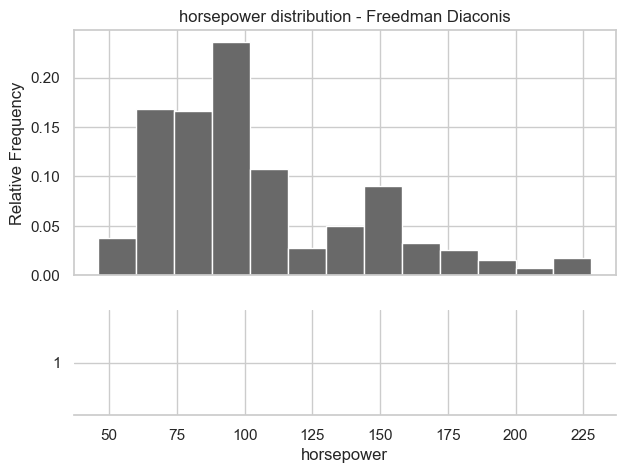

In [50]:
histogram_w_whiskers(df, 'horsepower')

The histogram shows that this distribution is multimodal. I'm not sure why my box-and-whiskers plot isn't working. Let's see if changing the bin numbers changes the distribuion shape and to look at the signal and noise of the data:

Freedman Diaconis for horsepower: 14 bins


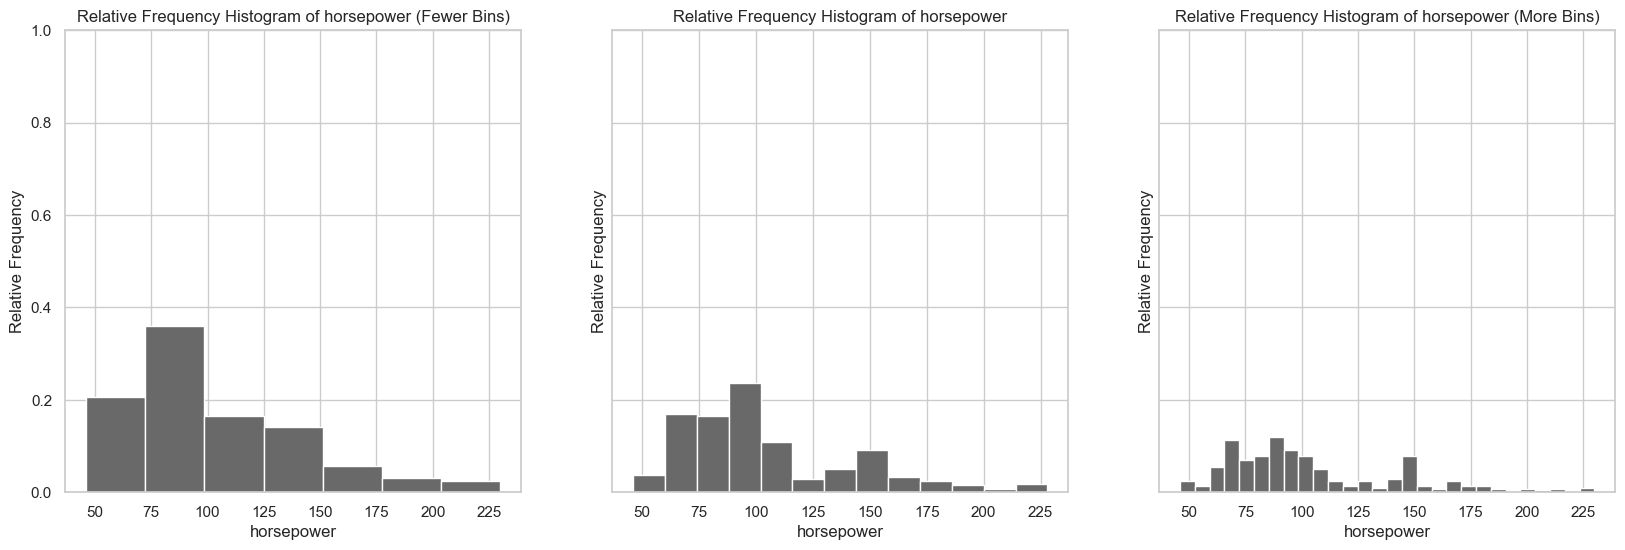

In [52]:
histogram_trio(df, 'horsepower')

When half the bins are used the distribution only looks right skewed. Having more bins had the same shape of distribution as the middle plot. We do not have a lot of data for cars with higher horsepower than cars with lower horsepower. Some questions that come up are:
1. Do cars with lower horsepower tends to have better mpg than cars with higher horsepower?
2. Does the most common value of horsepower at about 90 have a specific number of cylinders?
3. Are the same cars in the first lower group of horsepower and displacement's lower group?

### 5. <a id="step7"> weight</a>
<a href="#contents">^ Contents</a>

Average cars from the [mid-1970s](https://www.capitalone.com/cars/learn/finding-the-right-car/are-new-cars-and-trucks-getting-heavier/1260) weighed at 4,060 pounds. From [1975-1980](https://www.nber.org/digest/nov11/vehicle-weight-and-automotive-fatalities) average weight dropped almost 1,000 pounds (from 4,060 to 3,228 pounds). This is most likely in response to the rising gasoline prices and the passing of the Corporate Average Fuel Efficiency (CAFE) standard. I expect the range of the weight data to be between 3,000 to 5,000 pounds since there are cars with bigger engine sizes. Let's look at its descriptive statistics:

In [56]:
df.weight.describe()

count     398.000000
mean     2970.424623
std       846.841774
min      1613.000000
25%      2223.750000
50%      2803.500000
75%      3608.000000
max      5140.000000
Name: weight, dtype: float64

The minimum weight of the car is 1613 pounds in this data. I did not expect there to be such a low weighing vehicle. The maximum weight is 5140 pounds, which was very close to my hypothesis. The mean (2970.4) is greater than the median (2803.5), which indicates that the distribution is right skewed. The standard deviation of 846.8 pounds is very high for this distribution. Let's plot the histogram with the box-and-whiskers plot to visualize the distribution:

Freedman Diaconis for weight: 10 bins


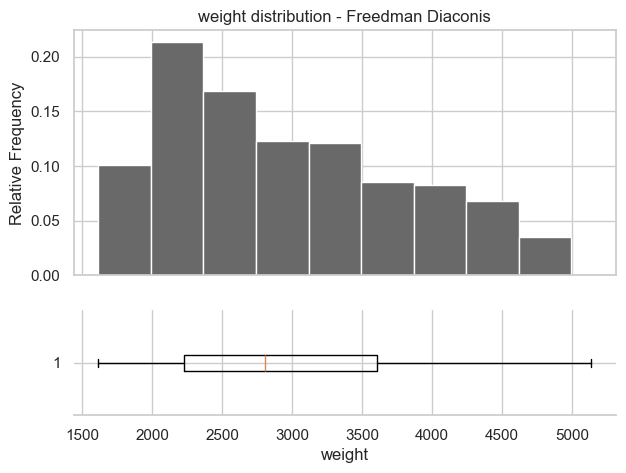

In [58]:
histogram_w_whiskers(df, 'weight')

The weight distribution is very right skewed. There are no extreme values present in the feature. Let's plot the histogram with fewer and more bins to see if the signal stays the same:

Freedman Diaconis for weight: 10 bins


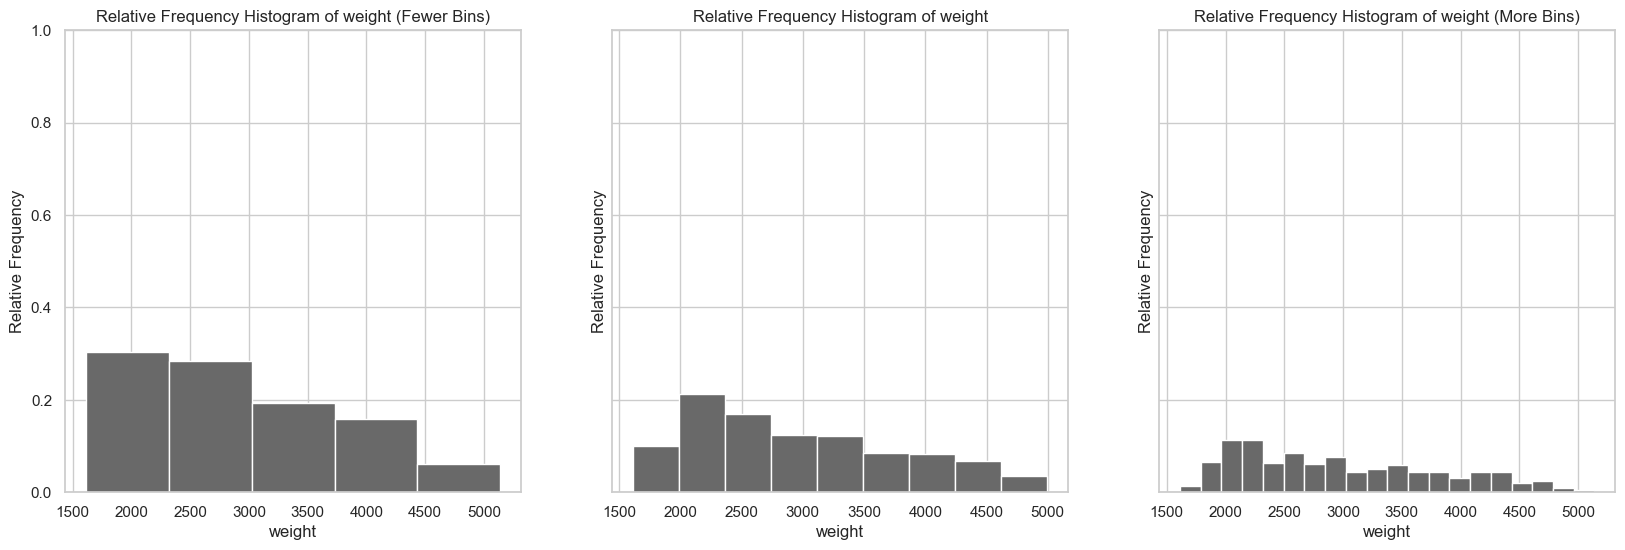

In [60]:
histogram_trio(df, 'weight')

The distribution stayed the same with fewer and more bins. The most frequent weight of the cars are between 2000 and 2300 pounds. Some following questions are:
1. Do the cars with the most frequent weight have a certain number of cylinders?
2. Do the cars with the most frequent weight get certain mpg?
3. Do cars that weigh less have higher mpg than cars that weigh more?

### 6. <a id="step8"> acceleration</a>
<a href="#contents">^ Contents</a>

The car's [acceleration](https://hypertextbook.com/facts/2001/MeredithBarricella.shtml) is measured by how long it takes for the vehicle to go from 0 to 60 miles per hour. In the image below the [average acceleration](https://web.mit.edu/sloan-auto-lab/research/beforeh2/files/MacKenzie%20&%20Heywood%20-%20TRB%20-%2012-1475.pdf) for U.S. light-duty vehicles were 14 seconds in 1975 and went slight up in 1976, then went down to about 13.5 seconds at 1979. Acceleration increased to about 14.5 seconds till 1982, but since then have declined in acceleration time, thus making the vehicles more faster.

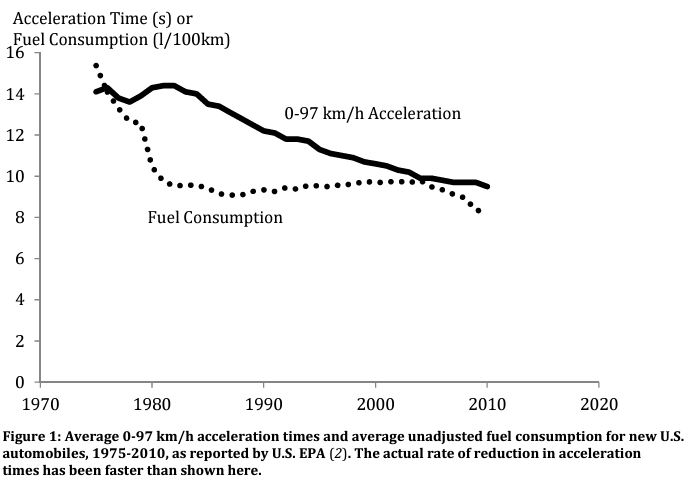

I expect this data to have an average of 14 seconds. Let's look at the descriptive statistics:

In [64]:
df.acceleration.describe()

count    398.000000
mean      15.568090
std        2.757689
min        8.000000
25%       13.825000
50%       15.500000
75%       17.175000
max       24.800000
Name: acceleration, dtype: float64

The minimum acceleration for this data is 8 seconds with a maximum acceleration of 24.8 seconds. The median (15.50) and mean (15.57) are very close, so I expect the distribution to be symmetrical, but with a slight right skewness. Let's look at the histogram with box-and-whiskers plot to look at the distribution:

In [66]:
def histogram_w_whiskers(data, variable_name, zoom=None):
    h = freedman_diaconis(data[variable_name])
    # If h is zero or too small, set a default bin width
    if h <= 0.0001:
        h = 1 
    
    mn = int(data[variable_name].min())
    mx = int(data[variable_name].max())
    bins = [i for i in range(mn, mx, h)]
    print(f"Freedman Diaconis for {variable_name}: {len(bins)} bins")

    observations = len(data)
    empirical_weights = np.ones(observations) / observations
        
    fig, ax = plt.subplots(
        2, figsize=(7, 5), sharex=True,
        gridspec_kw={"height_ratios": (.7, .3)}
    )

    ax[0].hist(data[variable_name], bins=bins, color="dimgray", weights=empirical_weights)
    ax[0].set_title(f"{variable_name} distribution - Freedman Diaconis")
    ax[0].set_ylabel("Relative Frequency")
    if zoom:
        ax[0].set_ylim((0, zoom))
    
    ax[1].boxplot(data[variable_name], vert=False)
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['left'].set_visible(False)
    ax[1].set_xlabel(variable_name)

    plt.show()
    plt.close()


Freedman Diaconis for acceleration: 16 bins


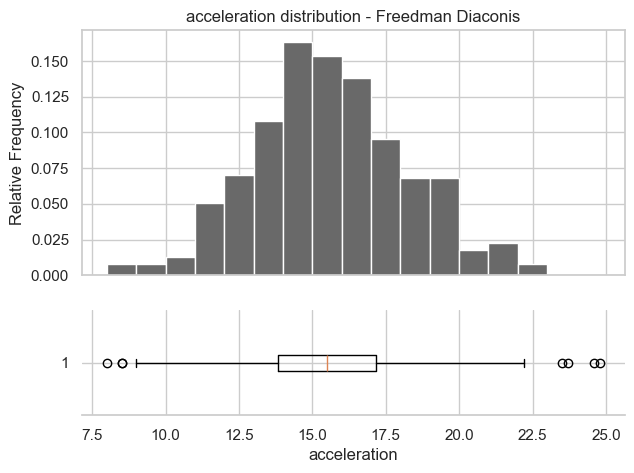

In [67]:
histogram_w_whiskers(df, 'acceleration')

The distribution is looking almost symmetrical. The median and the mean are not exactly the same so it has an ever so slight right skewness. The box-and-whiskers plot indicates that there are extreme values at both sides of the distribution. Let's see if changing the number of bins changes the signal and show any noise in the data:

Freedman Diaconis for acceleration: 16 bins


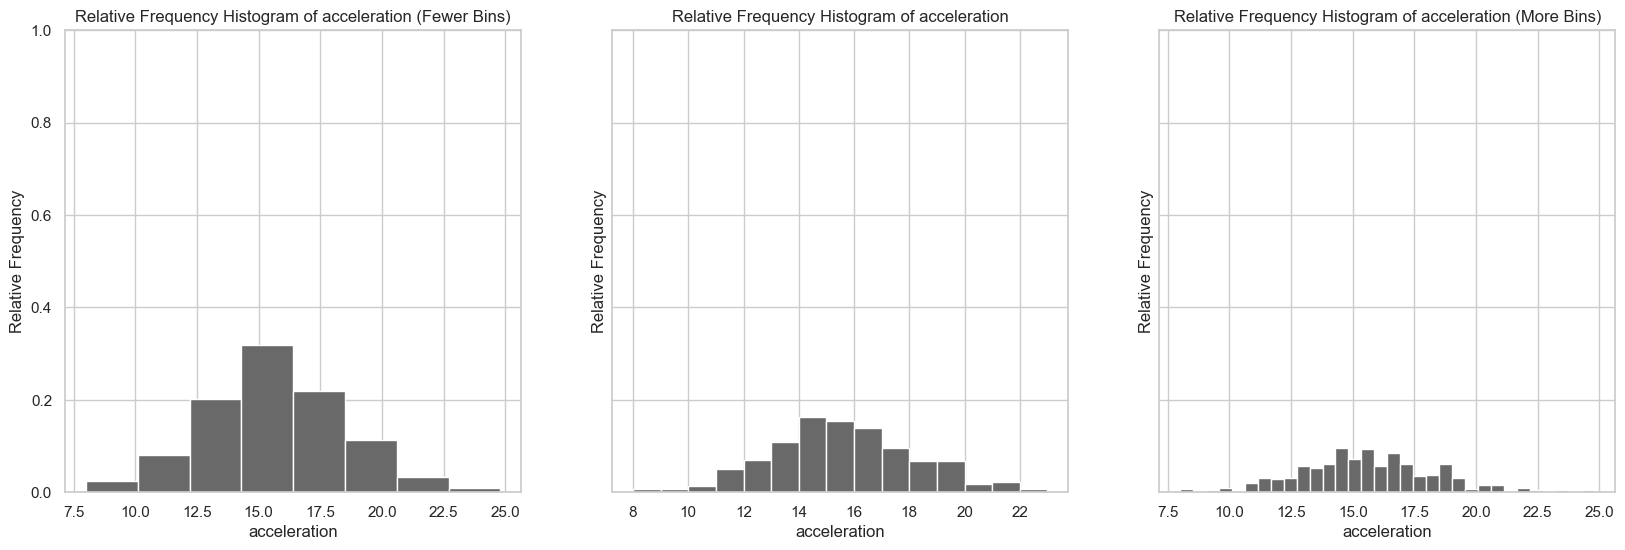

In [69]:
histogram_trio(df, 'acceleration')

The distribution shape stayed the same with fewer and more bins. The generalization of the data in the left plot makes the distribution very symmetrical. In the right plot with more bins it shows the peak at about 18.5 better than the other plots. Some questions that come up are:
1. Does vehicles with lower acceleration get better mpg than vehicles with higher acceleration?
2. Does acceleration and horsepower have any relationship with each other?
3. Does weight affect the vehicle's acceleration rate? 

### 7. <a id="step9"> model year</a>
<a href="#contents">^ Contents</a>

[Model year](https://en.wikipedia.org/wiki/Model_year) is a way to describe the version of the car that's been produced for multiple years. In general, new cars are [fully redesigned](https://www.autotrader.com/car-shopping/buying-car-why-you-should-pay-attention-model-cycles-239246) about every five to seven years. I would expect there to be multiple car data for every year present in this dataset. Let's look at the descriptive statistics:

In [73]:
df['model_year'].describe()

count    398.000000
mean      76.010050
std        3.697627
min       70.000000
25%       73.000000
50%       76.000000
75%       79.000000
max       82.000000
Name: model_year, dtype: float64

The range of model years are from 1970 to 1982. The median (76.0) and mean (76.01) are pretty much the same so I expect this distribution to be symmetrical. Let's look at the histogram with the box-and-whiskers plot:

Freedman Diaconis for model_year: 12 bins


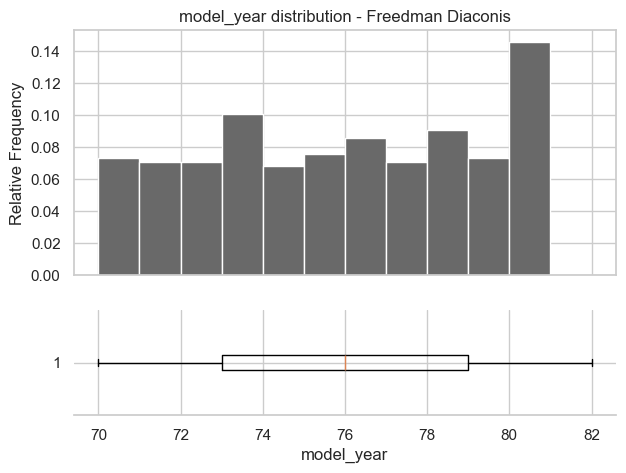

In [75]:
histogram_w_whiskers(df, 'model_year')

Even though the median and mean are the same, the shape of the distribution isn't symmetrical. The most common model year is 1980-1982. Let's see if we can see a better representation of the data by changing the number of bins used in the histogram:

Freedman Diaconis for model_year: 12 bins


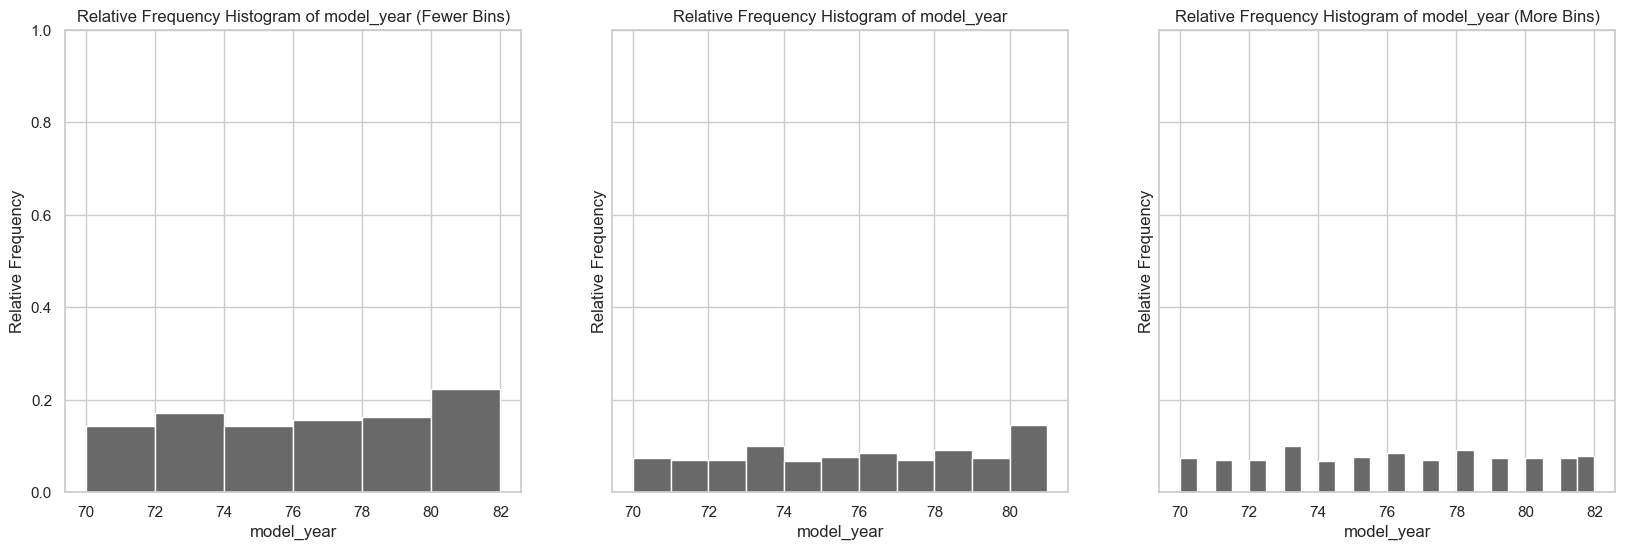

In [77]:
histogram_trio(df, 'model_year')

Using less bins obviously isn't the way to go. When I use more bins I can see a better separation of model year 80, 81, and 82. In the plots with fewer bins on the left and middle plots, it makes it seems like the most frequent model year is 1980. However, when you double the bins on the right plot you see that the most frequent model year is actually 1973. Also, why is that last bin (82) right next to (touching) the 81 neighboring bin unlike the other bins in the right plot? Some questions that come up are:
1. Do mpg decrease as the model year increase?
2. Do we have a mix of mpg values for cars in the same model year or do they all generally have similar mpg values?
3. Did certain model year release more of a certain number cylinder engines?

### 8. <a id="step10"> origin</a>
<a href="#contents">^ Contents</a>

In the 'names' variable that contained the dataset information did not discuss what origin is. My guess is that the origin will tell us where the cars came from. Let's look at the desciptive statistics:

In [81]:
df.origin.describe()

count    398.000000
mean       1.572864
std        0.802055
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: origin, dtype: float64

The range of this feature is from 1 to 3. The standard deviation of 0.8 is really high for this distribution. The median (1) is smaller than the mean (1.6), so this indicates that the distribution is right skewed. Let's plot the bar chart to see the distribution:

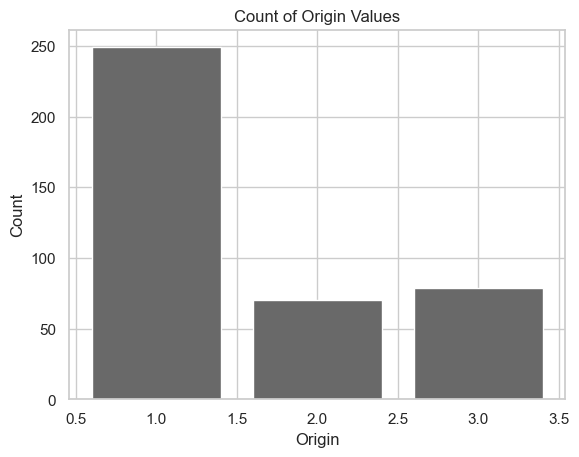

In [83]:
origin_counts = df['origin'].value_counts()

plt.bar(origin_counts.index, origin_counts.values, color='dimgray')

plt.xlabel('Origin')
plt.ylabel('Count')
plt.title('Count of Origin Values')

plt.show()

The most common origin value is 1. We do not have enough information on what these values represent. Some questions that come up are:
1. Do cars with lower mpg are seem more frequent in certain value of the origin?
2. Can we group the model year by the origin?
3. Does the origin categorize cars by a certain range of weight?

## <a id="step11"> Pairwise EDA</a>
<a href="#contents">^ Contents</a>

Let's explore if the target variable, 'mpg', have any relationship with other features from the data. I'll look at 5 different pairwise comparisons:

1. mpg vs. cylinders
2. mpg vs. displacement
3. mpg vs. horsepower
4. mpg vs. weight
5. mpg vs. model year

### <a id="step12">(1) mpg vs. cylinders</a>
<a href="#contents">^ Contents</a>

I hypothesize that mpg and cylinders features have a strong negative relationship with each other. Vehicles with less cylinders tends to get better gas mileage than vehicles with more cylinders in their engine. Let's look up the correlation coefficients:

In [87]:
print("r   = ", stats.pearsonr(df['mpg'], df['cylinders'])[0])
print("rho = ", stats.spearmanr(df['mpg'], df['cylinders'])[0])

r   =  -0.7753962854205525
rho =  -0.8218644914450965


The Pearson's correlation coefficient, $r$, is -0.78, which indicates that there is a strong negative relationship between the two features. It's stating that as you increase the number of cylinders in the engine, the less gas mileage the vehicle will have. Spearman's correlation coefficient is -0.82, which also indicates a strong monotonic decreasing relationship. These correlation coefficients supports my hypothesis of the 'mpg' and 'cylinders' features having a strong negative relationship. Let's plot a scatterplot of these variables:

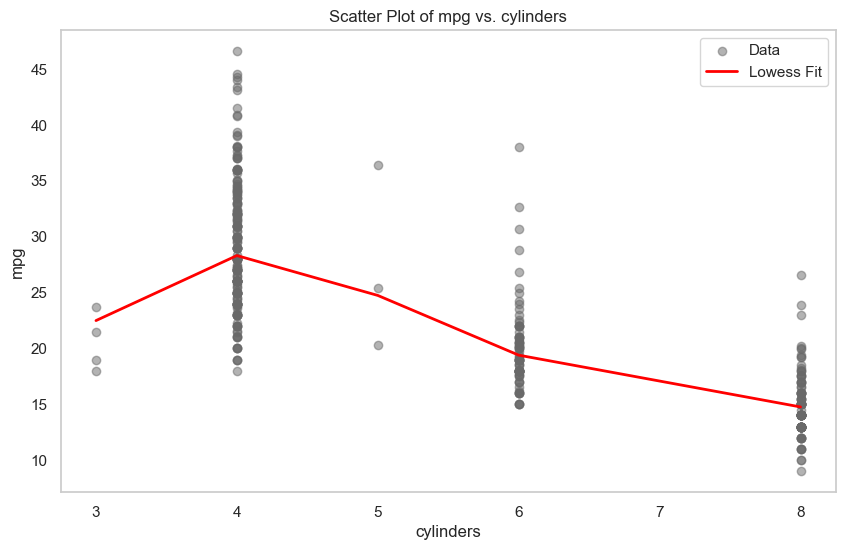

In [89]:
import statsmodels.api as sm

plt.figure(figsize=(10, 6))
plt.grid()
plt.scatter(df['cylinders'], df['mpg'], color='dimgray', alpha=0.5, label='Data')

lowess = sm.nonparametric.lowess(df['mpg'], df['cylinders'])
plt.plot(lowess[:, 0], lowess[:, 1], color='red', linewidth=2, label='Lowess Fit')

plt.title('Scatter Plot of mpg vs. cylinders')
plt.xlabel('cylinders')
plt.ylabel('mpg')
plt.legend()

plt.show()

The Lowess fit line actually shows us that when you go from 3 to 4 cylinders we have a positive relation between the features. However, we do not have enough data points for 3 cylinders to know if this is a true relationship. 4 cylinders have vehicles with mpg as low as 3 cylinders, but also span up to higher mpg values. From 4 cylinders and on to 8 cylinders, you see the negative relationship we saw in the correlation coefficients. We also do not have a lot of data points for 5 cylinders. If we were to only include the most common number of cylinders (4, 6, and 8), would we get a better relationship between 'mpg' and 'cylinders'? What about if we exclude just the 3 cylinders data points? Would the correlation coefficient be weaker with the 5 cylinders in the analysis with the common number of cylinders? If we were to add another variable, 'horsepower', would we see different separation in the analysis?

### <a id="step13">(2) mpg vs. displacement</a>
<a href="#contents">^ Contents</a>

I hypothesize that as you increase displacement, the mpg will decrease. The bigger the engine size, the more gas it will use, thus getting less mpg. Let's look up the correlation coefficients:

In [92]:
print("r   = ", stats.pearsonr(df['mpg'], df['displacement'])[0])
print("rho = ", stats.spearmanr(df['mpg'], df['displacement'])[0])

r   =  -0.8042028248058988
rho =  -0.8556920118178749


The Pearson's correlation coefficient is -0.80, which indicates that there is a strong negative relationship between 'mpg' and 'displacement'. As you increase displacement, the lower the mpg will be. Spearman's correlation coefficient is -0.86, which indicates that there is a strong decreasing monotonic relationship. Let's plot a scatterplot of these variables:

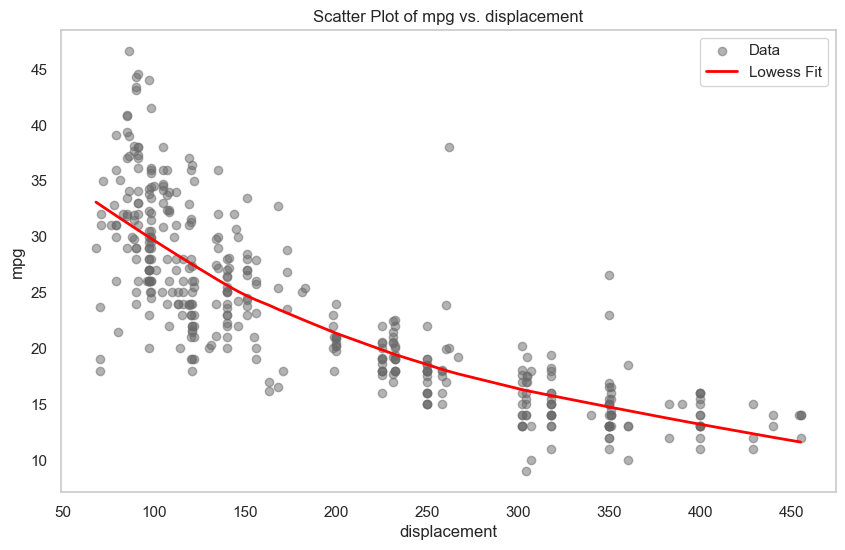

In [94]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.scatter(df['displacement'], df['mpg'], color='dimgray', alpha=0.5, label='Data')

lowess = sm.nonparametric.lowess(df['mpg'], df['displacement'])
plt.plot(lowess[:, 0], lowess[:, 1], color='red', linewidth=2, label='Lowess Fit')

plt.title('Scatter Plot of mpg vs. displacement')
plt.xlabel('displacement')
plt.ylabel('mpg')
plt.legend()

plt.show()

You see a nice negative Lowess fit line for these features, showing that there is a strong negative relationship between 'mpg' and 'displacement'. There is a slight bend in the line present. Just as we have seen in the previous histograms, we see groupings of the data for displacement. I'm curious if we group this by cylinder, would we see separations of displacement by different cylinder numbers? What if we group this data by model year instead? Would we see any separation of data or would it be all over the place? It would also be interesting to compare the relationship between 'displacement' and 'accelaration'. Perhaps the displacement could affect/vary the acceleration of the vehicle.

### <a id="step14">(3) mpg vs. horsepower</a>
<a href="#contents">^ Contents</a>

I hypothesize that there will be a negative relationship between horsepower and mpg. As you increase the horsepower, you will see lower mpg. Before looking up the correlation coefficients, I need to drop the rows that have missing values in the 'horsepower' feature:

In [97]:
df.dropna(subset=['horsepower'], inplace=True)
print(len(df.horsepower))

392


In [98]:
print("r   = ", stats.pearsonr(df['mpg'], df['horsepower'])[0])
print("rho = ", stats.spearmanr(df['mpg'], df['horsepower'])[0])

r   =  -0.7784267838977774
rho =  -0.8536164024453882


Just as I had suspected, the Pearson's correlation coefficient is -0.78, which indicates that there is a strong negative relationship between 'mpg' and 'horsepower'. As you increase the horsepower, the vehicle's mpg will decrease. Spearman's correlation coefficient is -0.85, which indicates that there is a strong monotonic decreasing relationship. Let's plot a scatterplot of the features:

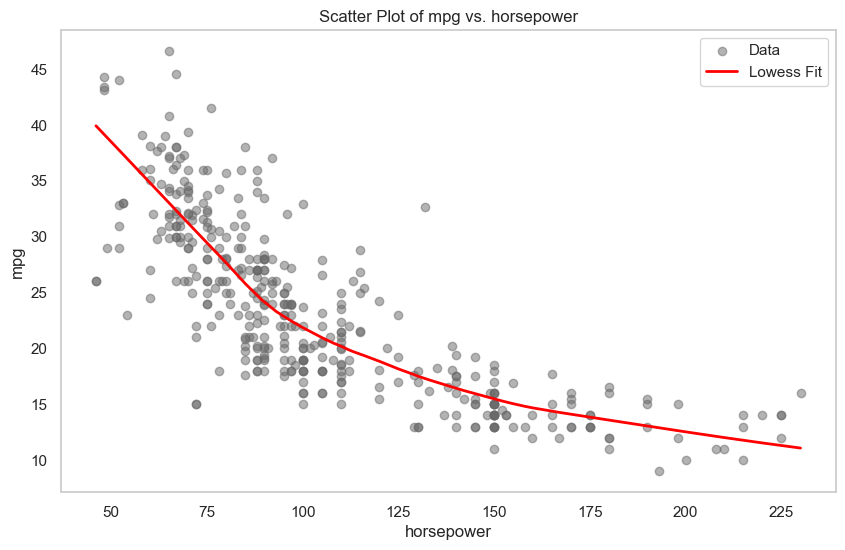

In [100]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.scatter(df['horsepower'], df['mpg'], color='dimgray', alpha=0.5, label='Data')

lowess = sm.nonparametric.lowess(df['mpg'], df['horsepower'])
plt.plot(lowess[:, 0], lowess[:, 1], color='red', linewidth=2, label='Lowess Fit')

plt.title('Scatter Plot of mpg vs. horsepower')
plt.xlabel('horsepower')
plt.ylabel('mpg')
plt.legend()

plt.show()

The Lowess fit line shows the strong negative relationship between 'mpg' and 'horsepower'. A bend in the line is present, much greater than the displacement's Lowess fit line. There is also not as much data points for vehicles with higher horsepower. Since I saw similar results in this pairwise comparison as the 'mpg' and 'displacement' comparison, I'm curious there would be any relationship between 'horsepower' and 'displacement' features. Later on, I would like to explore the pairing of those features. What if this data was grouped by 'cylinders'? Would we see good separation of this data by the different number of cylinders? Also, if we were to group this data between 'mpg' and 'horsepower' by model year, would we see good separation of the model years or would they be spread out?

### <a id="step15">(4) mpg vs. weight</a>
<a href="#contents">^ Contents</a>

I hypothesize that there will also be a negative relationship between 'mpg' and 'weight'. As the vehicles weighs more, it would require more gas to run and drive, so I suspect that it will get less mpg. Let's look at the correlation coefficients:

In [103]:
print("r   = ", stats.pearsonr(df['mpg'], df['weight'])[0])
print("rho = ", stats.spearmanr(df['mpg'], df['weight'])[0])

r   =  -0.8322442148315756
rho =  -0.8755851198739869


Pearson's correlation coefficient is -0.83, which indicates a strong negative relationship. Just as I suspected, as you increase the weight of the vehicle, the less mpg it will have. Spearman's correlation coefficient is -0.88, which indicates that there is a strong monotonic decreasing relationship as well. Let's plot a scatterplot to visualize the relationship:

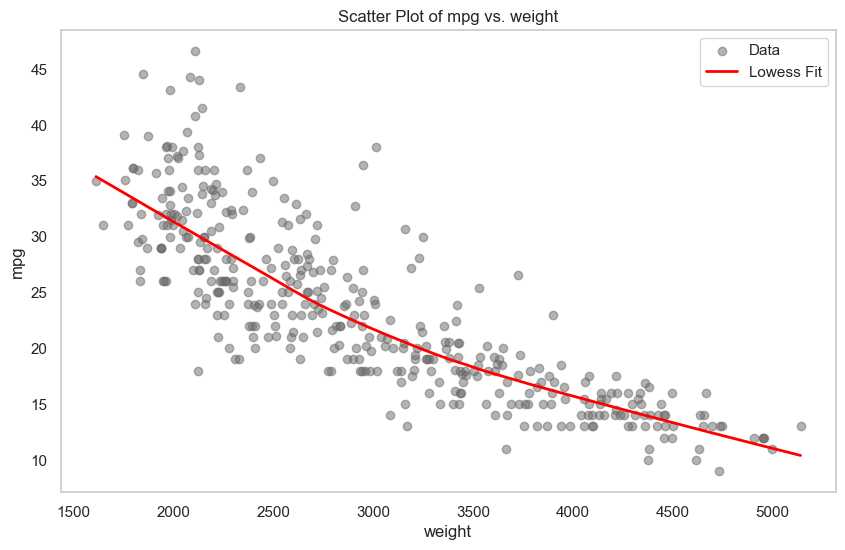

In [105]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.scatter(df['weight'], df['mpg'], color='dimgray', alpha=0.5, label='Data')

lowess = sm.nonparametric.lowess(df['mpg'], df['weight'])
plt.plot(lowess[:, 0], lowess[:, 1], color='red', linewidth=2, label='Lowess Fit')

plt.title('Scatter Plot of mpg vs. weight')
plt.xlabel('weight')
plt.ylabel('mpg')
plt.legend()

plt.show()

There is a slight bend in the Lowess fit line for this pairwise comparison. We have much less data for vehicles that weight more, so that could be affecting the bend of the line. It would be interesting to explore if we see any separation of data when grouped by cylinders. I would also like to see if 'weight' and 'acceleration' have any relationship with each other. Generally, the heavier the vehicle is the acceleration could be lower due to the weight. It would also be interesting to explore if cars' weight changes over time by grouping the data with model year. If we were to group this data between 'mpg' and 'weight' by cylinders, would it show that certain number of cylinders would have certain range of weight and mpg?

### <a id="step16">(5) mpg vs. model year</a>
<a href="#contents">^ Contents</a>

I hypothesis that we will see mpg getting better as the years go by. I expect there to be a positive relationship between these two features. Let's look at the correlation coefficients:

In [108]:
print("r   = ", stats.pearsonr(df['mpg'], df['model_year'])[0])
print("rho = ", stats.spearmanr(df['mpg'], df['model_year'])[0])

r   =  0.5805409660907846
rho =  0.5748408744472727


Pearson's correlation coefficient is 0.58, which indicates that there is a moderate positive relationship between 'mpg' and 'model year'. There is a positive relationship as I had suspected, but isn't as great as I had hoped. Spearman's correlation coefficient is 0.57, which indicates that there is a moderate monotonic non-decreasing relationship. Let's plot a scatterplot of these features:

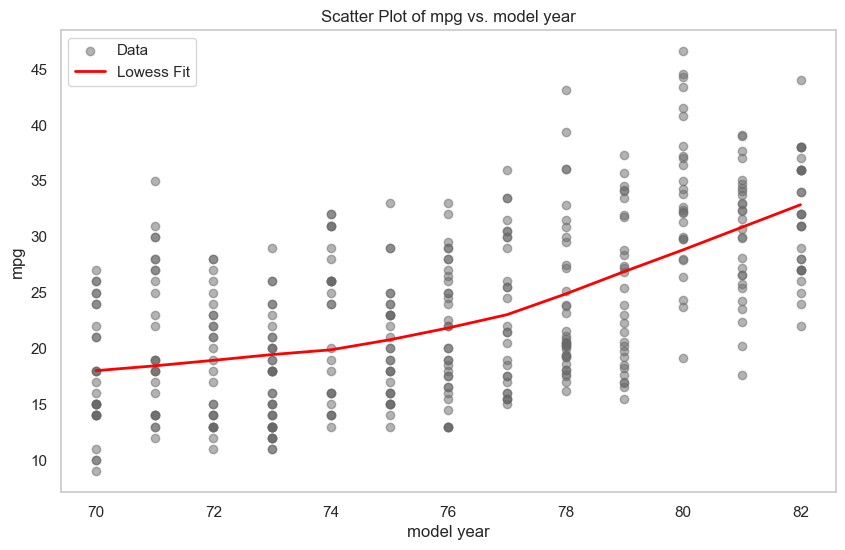

In [110]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.scatter(df['model_year'], df['mpg'], color='dimgray', alpha=0.5, label='Data')

lowess = sm.nonparametric.lowess(df['mpg'], df['model_year'])
plt.plot(lowess[:, 0], lowess[:, 1], color='red', linewidth=2, label='Lowess Fit')

plt.title('Scatter Plot of mpg vs. model year')
plt.xlabel('model year')
plt.ylabel('mpg')
plt.legend()

plt.show()

There are two bends in the Lowess fit line at about 74 and 77 model year. I wonder if we were able to get more data points, would be see a better relationship between these features? Also, since smaller number of cylinders tends to get better mpg, if we were to group this data by 'cylinders' would be see 4 cylinders data points more on the right side of this plot? It would also be interesting to explore how the acceleration and mpg changes over time with the model year.

Summary - During the pairwise EDA, we saw that 'mpg' has strong negative relationships with 'cylinders', 'displacement', 'horsepower', and 'weight'. As you increase the 'mpg' of the vehicles, the 'cylinders', 'displacement', 'horsepower', and 'weight' values of the vehicles decreases. Also, 'mpg' has a moderate positive relationship with 'model year'. This indicates that as you increase 'mpg' of the vehicle, the 'model year' also increases. 

## <a id="step17">Digging Deeper</a>
<a href="#contents">^ Contents</a>

Early in the pairwise comparison, I was curious earlier was to see if there are any separation in the data between mpg and displacement when grouped by cylinders. Let's plot it and see:

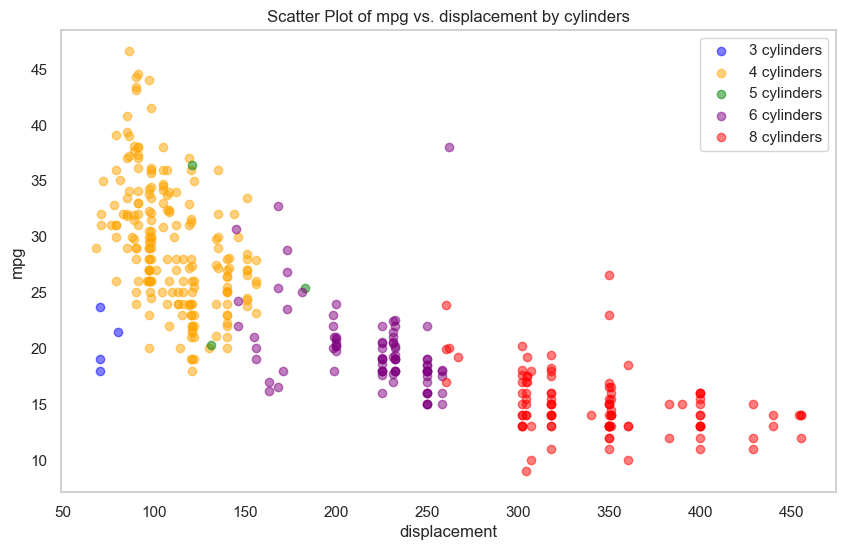

In [114]:
plt.figure(figsize=(10, 6))
plt.grid()

grouped = df.groupby('cylinders')

cylinder_colors = {3: 'blue', 4: 'orange', 5: 'green', 6: 'purple', 8: 'red'}

for name, group in grouped:
    plt.scatter(group['displacement'], group['mpg'], color=cylinder_colors[name], label=f'{name} cylinders', alpha=0.5)

plt.title('Scatter Plot of mpg vs. displacement by cylinders')
plt.xlabel('displacement')
plt.ylabel('mpg')
plt.legend()
plt.show()

When mpg and displacement are grouped by cylinders, we see nice separation of 3 and 8 cylinders. We see overlapping between 4, 5, and 6 cylinders. 5 cylinders data points are spread out more than other cylinder values. It appears that there is a positive relationship between displacement and cylinders. If we had more data points for 3 cylinders, would we still see a good separation of its group?

I also want to explore if 'horsepower' and 'displacement' have any relationship with each other. They both acted in similar ways with 'mpg' and their distribution histograms looked very similar to each other. Let's look at the correlation coefficients:

In [117]:
print("r   = ", stats.pearsonr(df['horsepower'], df['displacement'])[0])
print("rho = ", stats.spearmanr(df['horsepower'], df['displacement'])[0])

r   =  0.8972570018434707
rho =  0.8761707908903555


Pearson's correlation coefficient of 0.897 indicates that there is a very strong positive relationship between these variables. As you increase the displacement, horsepower also increases. Spearman's correlation coefficient of 0.876 indicates that there is a strong monotonic non-decreasing relationship. If we visualize the data with a scatterplot:

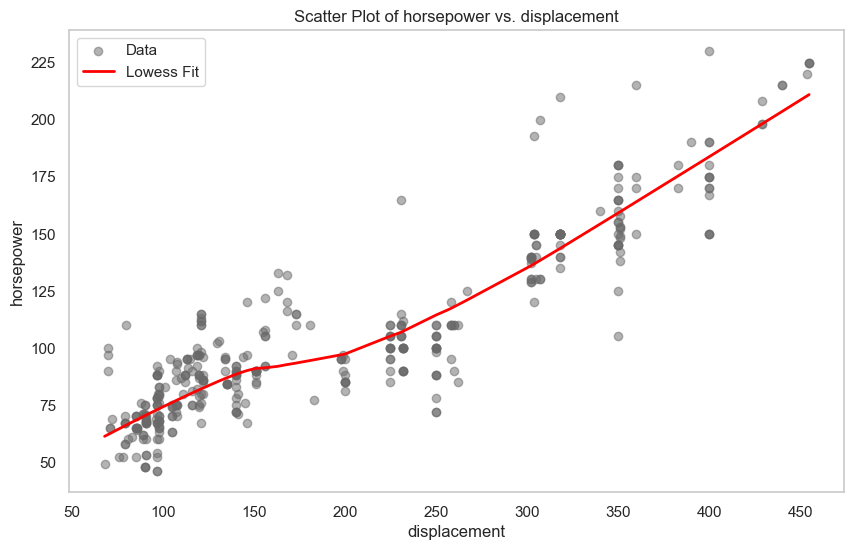

In [119]:
plt.figure(figsize=(10, 6))
plt.grid()
plt.scatter(df['displacement'], df['horsepower'], color='dimgray', alpha=0.5, label='Data')

lowess = sm.nonparametric.lowess(df['horsepower'], df['displacement'])
plt.plot(lowess[:, 0], lowess[:, 1], color='red', linewidth=2, label='Lowess Fit')

plt.title('Scatter Plot of horsepower vs. displacement')
plt.xlabel('displacement')
plt.ylabel('horsepower')
plt.legend()

plt.show()

You can clearly see that there is a very strong positive relationship between these variables. However, there are two bends in the Lowess fit line at 150 and 200 cu in. Will this relationship affect the prediction of the target variable? Would we possibly see an interactive term between these features? If we were to group this data with cylinders, would we get a good separation of the different values for cylinders?

## <a id="step18">Null & Distributional Models</a>
<a href="#contents">^ Contents</a>

### <a id="step19">Null Model</a>
<a href="#contents">^ Contents</a>

I would like to predict what the next value for mpg will be for this auto data. We want to penalize underestimates and overestimates the same while penalizing large errors more than small errors. I would like to use the mean as the predictions since the mean minimizes the Mean Square Error (MSE) loss.

The mean (location) of the mpg is:

In [124]:
mpg_hat = np.mean(df.mpg)
mpg_hat

23.445918367346938

We can predict that the next mpg will be 23.4 at random. Let's get the standard deviation to get the error bounds:

In [126]:
mpg_std = np.std(df.mpg)
mpg_std

7.795045762682584

The standard deviation, the scale parameter, is 7.8 mpg. Let's get the 95% error bounds for the prediction:

In [128]:
print(mpg_hat, '(', mpg_hat-1.96*mpg_std, ',', mpg_hat+1.96*mpg_std, ')')

23.445918367346938 ( 8.167628672489073 , 38.7242080622048 )


I predict that the next random number of mpg to generally be 23.446 mpg with an error up to 7.795 95% of the time while ranging between 8.168 and 38.724 mpg.

### <a id="step20">Distributional Model</a>
<a href="#contents">^ Contents</a>

The data generating story for the target variable is that the miles per gallon represents how many miles a vehicle can travel per gallon consumed. The vehicle's number of cyclinders, the engine size (displacement), horsepower, acceleration, and weight influences the vehicle's mpg that it can have. If I assume that these variables are independent, then these variables are additive. Each predictor variable contributes independently to the target variable, and the effects of the predictor variables are additive and independent of each other. This suggests that the data follows a Gaussian distribution.

The parameters of the Gaussian distribution are $\mu$ (mean) and $\sigma$ (standard deviation). The Method of Moment estimators for the parameters of the Gaussian distribution becomes $\bar{x}$ -> $\mu$ and $s$ -> $\sigma$. Let's plot the Gaussian normal distribution over the data:

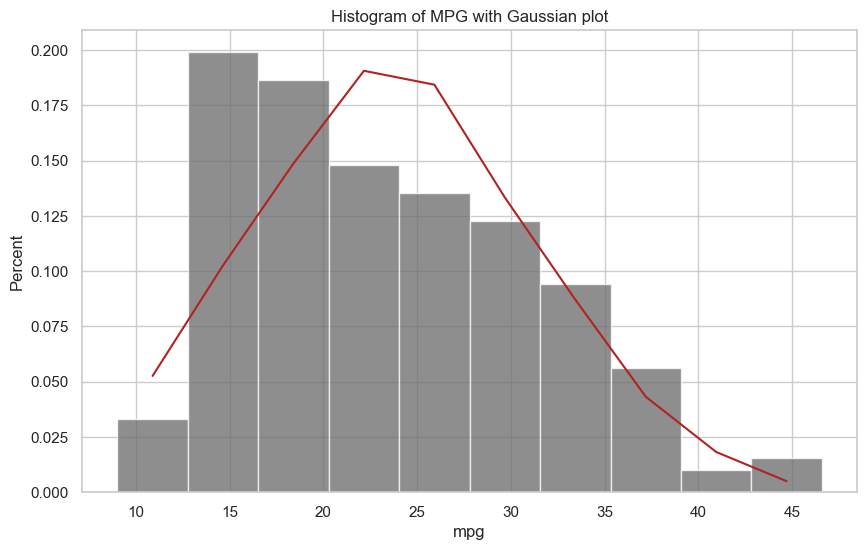

In [133]:
figure = plt.figure(figsize=(10,6))
data = df['mpg']
data_mu = mpg_hat
data_sigma = mpg_std
observations = len(data)

axes = figure.add_subplot(1, 1, 1)

empirical_weights = np.ones(observations)/observations

n, bins, patches = axes.hist(data, color="DimGray", weights=empirical_weights, alpha=0.75)
axes.set_xlabel("mpg")
axes.set_ylabel("Percent")
axes.set_title("Histogram of MPG with Gaussian plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]

sampled_data = [data_mu + r * data_sigma for r in np.random.standard_normal(10000)]
theoretical_weights = np.ones(len(sampled_data))/len(sampled_data)

values2, base = np.histogram(sampled_data, bins=bins, weights=theoretical_weights)
axes.plot(xs, values2, color="firebrick")
plt.show()
plt.close()

The model over estimated between 10-15, 20-30, and 40-45 while underestimating between 15-20 mpg. Let's look at the difference between the model and the empirical distribution using a cumulative distribution chart and a difference in cumulative distributions chart:

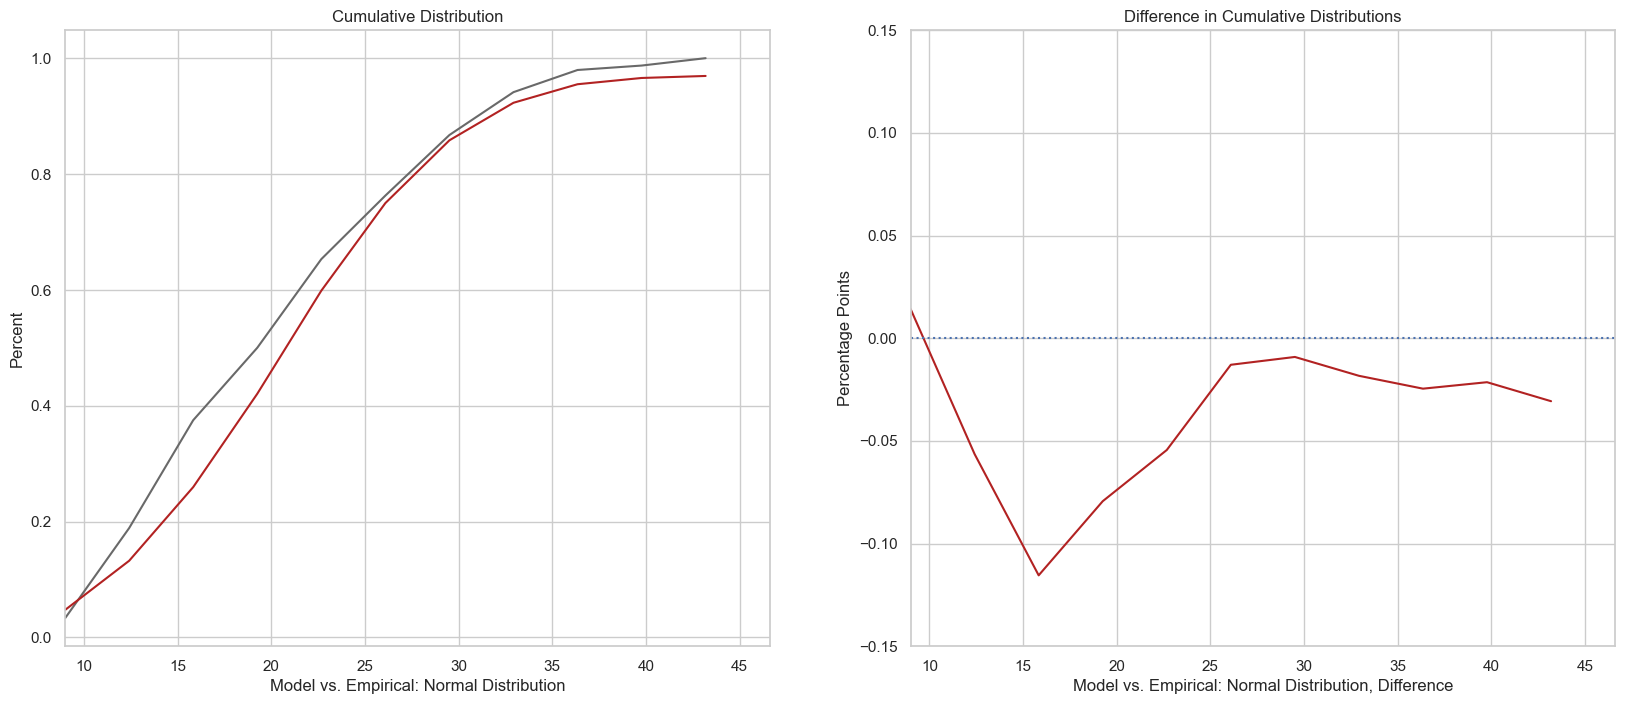

In [135]:
figure = plt.figure(figsize=(20, 8))

data = df['mpg']
data_mn = np.min(data)
data_mx = np.max(data)
data_mu = np.mean(data)
data_sigma = np.std(data)

observations = len(data)
empirical_weights = np.ones(observations)/observations

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(data, bins=11, weights=empirical_weights)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="dimgray")
axes.set_xlim((data_mn, data_mx))

sampled_data = [data_mu + r * data_sigma for r in np.random.standard_normal(10000)]
values2, base = np.histogram(sampled_data, bins=base, weights=theoretical_weights)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
axes.set_title("Cumulative Distribution")
axes.set_xlim((data_mn, data_mx))
axes.set_ylabel("Percent")
axes.set_xlabel( "Model vs. Empirical: Normal Distribution")

axes = figure.add_subplot(1, 2, 2)
differences = cumulative2 - cumulative

axes.plot(base[:-1], differences, color='firebrick')
axes.hlines(0, data_mn, data_mx, linestyles="dotted")
axes.set_xlim((data_mn, data_mx))
axes.set_ylim((-0.15, 0.15))
axes.set_title("Difference in Cumulative Distributions")
axes.set_xlabel( "Model vs. Empirical: Normal Distribution, Difference")
axes.set_ylabel("Percentage Points")

plt.show()
plt.close()

The difference in cumulative distribution chart allows us to easily see the difference between the model and the empirical data. You can see that the model underestimated more between 10 and 25 mpg with the highest percentage point difference at 16 with -12 percentage points. Other than that the percentage point difference between 25 to 45 mpg is less than -5 percentage points.

Before we move on to making predictions, let's look up the cumulative absolute prediction error:

In [138]:
sum([np.abs(diff) for diff in differences])

0.4372387755108307

The cumulative absolute prediction error is 43.7 percentage points. Seems kind of high, but let's see how that compares to the use of the Uniform distribution as the model:

In [140]:
uniform_values = [1/len(bins) for _ in range(0, len(bins))]
uniform_differences = uniform_values - values
sum([np.abs(diff) for diff in uniform_differences])

0.5774582560296853

The cumulative absolute prediction error with the Uniform distribution is 57.7 percentage points. The Gaussian distribution is an improvement over the Uniform distribution.

Earlier in the digging deeper section, we saw that 'horsepower' and 'displacement' have a very strong positive relationship. What if there is an interactive term between these variables, thus combining the small effects in a multiplicative way? Then, a Galton distribution would be appropriate to follow and use. Let's plot the Galton distribution over the data:

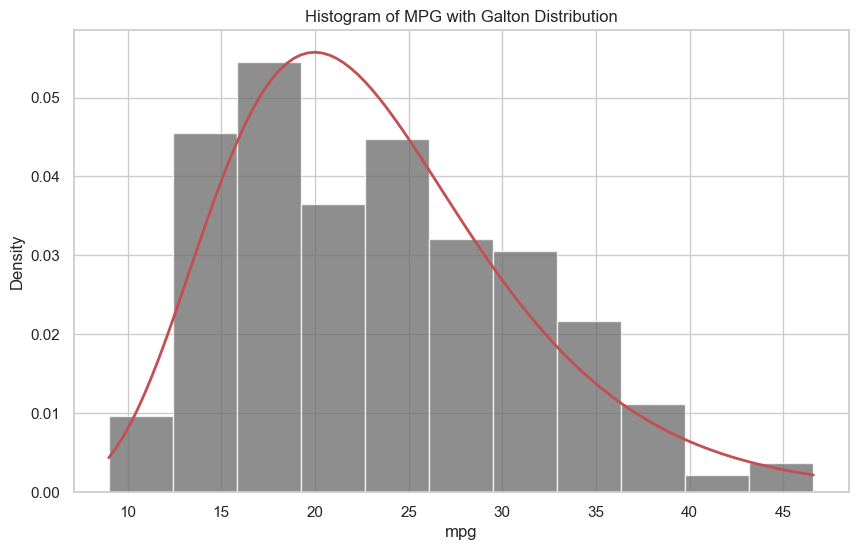

In [143]:
plt.figure(figsize=(10, 6))

# Fit a log-normal distribution to the 'mpg' data
shape, loc, scale = lognorm.fit(df['mpg'])

# Generate a range of values from the log-normal distribution
x = np.linspace(df['mpg'].min(), df['mpg'].max(), 100)
pdf = lognorm.pdf(x, shape, loc=loc, scale=scale)

# Plot the histogram of 'mpg' data
plt.hist(df['mpg'], bins=11, density=True, alpha=0.75, color='DimGray')

# Plot the PDF of the log-normal distribution
plt.plot(x, pdf, 'r-', linewidth=2)

plt.title('Histogram of MPG with Galton Distribution')
plt.xlabel('mpg')
plt.ylabel('Density')

plt.show()

The model underestimated between 13-19 and about 30-40 while overestimating between 19-23 and 40-43. Let's plot the cumulative distribution chart to see the differences between the model and the empirical distribution in an easier way:

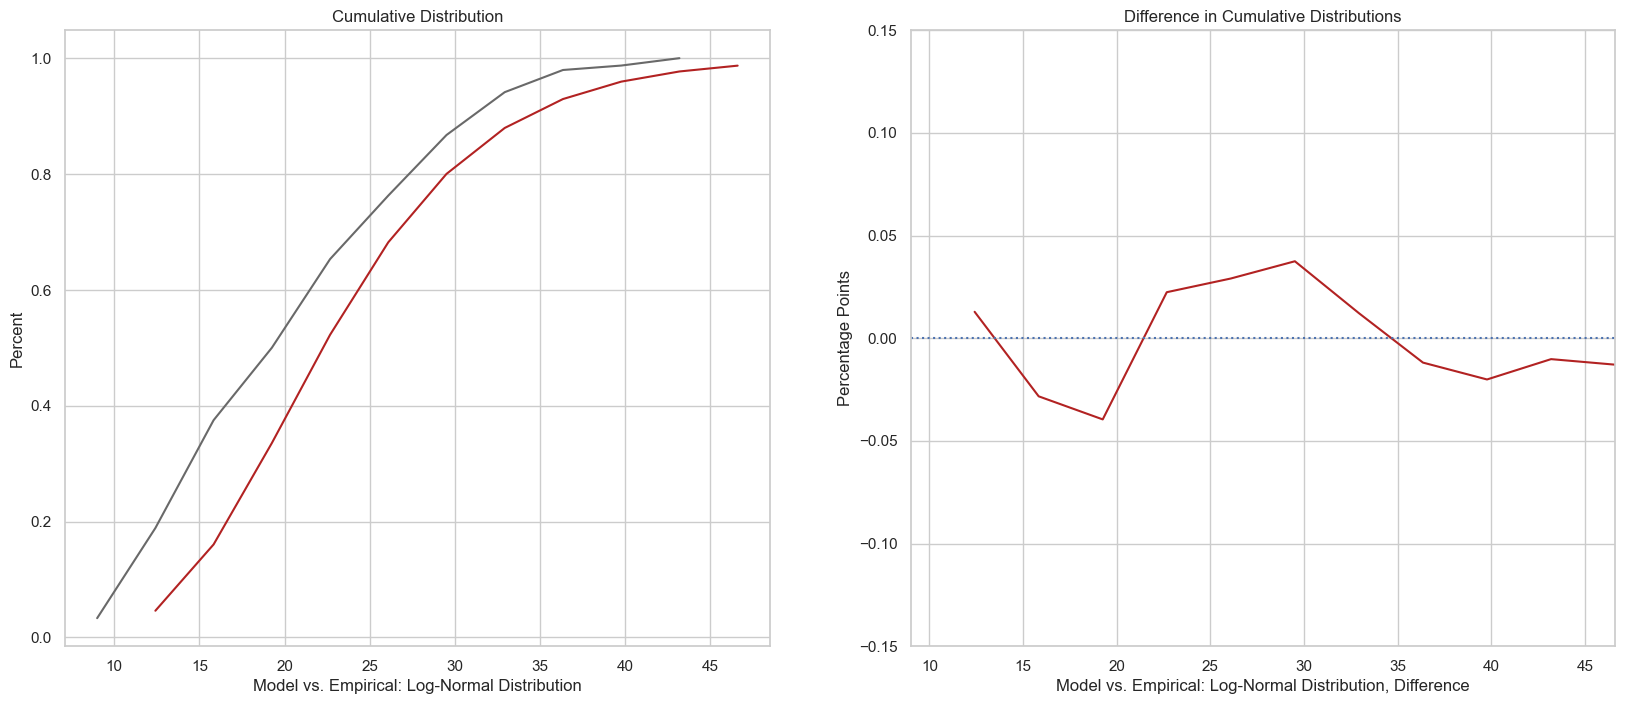

In [145]:
# Calculate the cumulative distribution of the empirical 'mpg' data
empirical_values, empirical_base = np.histogram(df['mpg'], bins=11, density=True)
empirical_cumulative = np.cumsum(empirical_values * np.diff(empirical_base))

# Calculate the cumulative distribution of the log-normal distribution
lognorm_values = lognorm.cdf(empirical_base[1:], shape, loc=loc, scale=scale)

plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(empirical_base[:-1], empirical_cumulative, color="dimgray", label="Empirical Cumulative Distribution")
plt.plot(empirical_base[1:], lognorm_values, color="firebrick", label="Modeled Cumulative Distribution")
plt.title("Cumulative Distribution")
plt.xlabel("Model vs. Empirical: Log-Normal Distribution")
plt.ylabel("Percent")

# Calculate the difference in cumulative distributions
differences = lognorm_values - empirical_cumulative

plt.subplot(1, 2, 2)
plt.plot(empirical_base[1:], differences, color='firebrick')
plt.hlines(0, df['mpg'].min(), df['mpg'].max(), linestyles="dotted")
plt.xlim((df['mpg'].min(), df['mpg'].max()))
plt.ylim((-0.15, 0.15))
plt.title("Difference in Cumulative Distributions")
plt.xlabel("Model vs. Empirical: Log-Normal Distribution, Difference")
plt.ylabel("Percentage Points")

plt.show()

The plot on the right shows us the difference in cumulative distributions between the model and empirical data. Let's look up the cumulative absolute prediction error of this model:

In [147]:
sum([np.abs(diff) for diff in differences])

0.23692475371770627

The cumulative absolute prediction error is 23.7 percentage points, which is 20 percentage points lower than the Gaussian distribution. In conclusion, we have multiplicative effects and the Galton distribution is a better model for the data.

### <a id="step21">Null Model Prediction</a>
<a href="#contents">^ Contents</a>

I would like to predict what the next value for mpg will be for this auto data. We want to penalize underestimates and overestimates the same while penalizing large errors more than small errors. I would like to use the mean as the predictions since the mean minimizes the Mean Square Error (MSE) loss.

The mean (location) of the mpg is:

In [152]:
mpg_hat = np.mean(df.mpg)
mpg_hat

23.445918367346938

We can predict that the next mpg will be 23.4 at random. Let's get the standard deviation to get the error bounds:

In [154]:
mpg_std = np.std(df.mpg)
mpg_std

7.795045762682584

The standard deviation, the scale parameter, is 7.8 mpg. Let's get the 95% error bounds for the prediction:

In [156]:
print(mpg_hat, '(', mpg_hat-1.96*mpg_std, ',', mpg_hat+1.96*mpg_std, ')')

23.445918367346938 ( 8.167628672489073 , 38.7242080622048 )


I predict that the next random number of mpg to generally be 23.446 mpg with an error up to 7.795 95% of the time while ranging between 8.168 and 38.724 mpg.

### <a id="step22">Distributional Model Predictions</a>
<a href="#contents">^ Contents</a>

1. What is the probability that a random car will have more than 30 mpg?

In [175]:
stats.norm.sf(30, mpg_hat, mpg_std)

0.2002297364092971

There is 20% probability of observing a random car that gets more than 30 mpg.

2. What is the probability that a random car's mpg will be between 15-20 mpg?

In [178]:
stats.norm.cdf(20, mpg_hat, mpg_std) - stats.norm.cdf(15, mpg_hat, mpg_std)

0.18992735167567293

There is 19% probability that a random car's mpg will be between 15 to 20 mpg.

3. What mpg value or lower would we likely see with 10% probability?

In [181]:
stats.norm.ppf([0.10], mpg_hat, mpg_std)

array([13.45616527])

We are likely to see a car with 13.5 mpg or lower with 10% probability.

4. What is the probability that a random car's mpg will be between 20-25 mpg?

In [389]:
stats.norm.cdf(25, mpg_hat, mpg_std) - stats.norm.cdf(20, mpg_hat, mpg_std)

0.24979148470911416

There is 25% probability that a random car's mpg will be between 20 to 25 mpg.

## <a id="step23">Build The Linear Model</a>
<a href="#contents">^ Contents</a> 

Let's build a linear regression model with all the features included. 

In [185]:
import models

In [186]:
model = "mpg ~ cylinders + displacement + horsepower + weight + acceleration + model_year + origin"
result1 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result1)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-17.218435,-27.598662,-6.535537
cylinders,$\beta_{1}$,-0.493376,-1.110781,0.105512
displacement,$\beta_{2}$,0.019896,0.003455,0.033949
horsepower,$\beta_{3}$,-0.016951,-0.039550,0.012094
weight,$\beta_{4}$,-0.006474,-0.007770,-0.005181
acceleration,$\beta_{5}$,0.080576,-0.137904,0.277099
model_year,$\beta_{6}$,0.750773,0.665836,0.857964
origin,$\beta_{7}$,1.426140,0.894245,1.922090
,,,,


The Coefficient of Determination ($R^2$) of 0.82 is pretty good. The error ($\sigma$) 3.33 decreased to about a half from the null model (7.80). 
The intercept is estimated to be -17.22. Given the data and priors, there is 95% probability that the intercept will be between -25.10 and -9.79. 
The 'cylinders' effect of $\beta_1$ is estimated to be -0.49. Given the data and prior, there is 95% probability that $\beta_1$ will be between -1.09 and 0.13. If we increase 'cylinders' by 1, 'mpg' decreases by 0.49. 
The 'displacement' effect of $\beta_2$ is estimated to be 0.02. There is 95% probability that $\beta_2$ will be between 0.00 and 0.04 given the data and the priors. If we increase 'displacement' by 1, 'mpg' increases by 0.02. 
The 'horsepower' effect of $\beta_3$ is estimated to be -0.02. There is 95% probability that $\beta_3$ will be between -0.04 and 0.01 given the data and the priors. If we increase 'horsepower' by 1, 'mpg' decreases by 0.02. 
The 'weight' effect of $\beta_4$ is estimated to be -0.01. There is 95% probability that $\beta_4$ is going to be -0.01 given the data and priors. If we increase 'weight' by 1, 'mpg' decreases by 0.01. 
The 'acceleration' effect of $\beta_5$ is estimated to be 0.08. There is 95% probability that $\beta_5$ will be between -0.14 and 0.34 given the data and priors. If we increase 'acceleration' by 1, 'mpg' increases by 0.08. 
The 'model_year' effect of $\beta_6$ is estimated to be 0.75. There is 95% probability that $\beta_6$ will be between 0.67 and 0.84 given the data and priors. If we increase 'model_year' by 1, 'mpg' increases by 0.75. 
The 'origin' effect of $\beta_7$ is estimated to be 1.43. There is 95% probability that $\beta_7$ will be between 0.88 and 1.87 given the data and priors. If we increase 'origin' by 1, 'mpg' increases by 1.43.

I'll use Gelman's table to evaluate the coefficients. 'Credible' indicates that the 95% credible interval includes 0:

| coefficient  |     value | expected | credible | decision |
|--------------|----------:|----------|----------|----------|
| cylinders    |     -0.49 | yes      | yes      | keep     |
| displacement |      0.02 | no       | yes      | remove   |
| horsepower   |     -0.02 | yes      | yes      | keep     |
| weight       |     -0.01 | yes      | no       | keep     |
| acceleration |      0.08 | no       | yes      | remove   |
| model_year   |      0.75 | yes      | no       | keep     |
| origin       |      1.43 | yes      | no       | keep     |

Before we start removing coefficients, let's examine the patterns in the residuals:

In [189]:
def plot_residuals(result, variables):
    figure = plt.figure(figsize=(20,8))

    variables = ["cylinders", "horsepower", "weight", "model_year", "origin"]

    plots = len( variables)
    rows = (plots // 3) + 1

    residuals = np.array([r[0] for r in result["residuals"]])
    limits = max(np.abs(residuals.min()), residuals.max())
    
    n = result["n"]
    for i, variable in enumerate( variables):
        axes = figure.add_subplot(rows, 3, i + 1)

        keyed_values = sorted(zip(df[variable].values, residuals), key=lambda x: x[ 0])
        ordered_residuals = [x[ 1] for x in keyed_values]

        axes.plot(list(range(0, n)), ordered_residuals, '.', color="dimgray", alpha=0.75)
        axes.axhline(y=0.0, xmin=0, xmax=n, c="firebrick", alpha=0.5)
        axes.set_ylim((-limits, limits))
        axes.set_ylabel("residuals")
        axes.set_xlabel(variable)

    plt.show()
    plt.close()
    
    return residuals

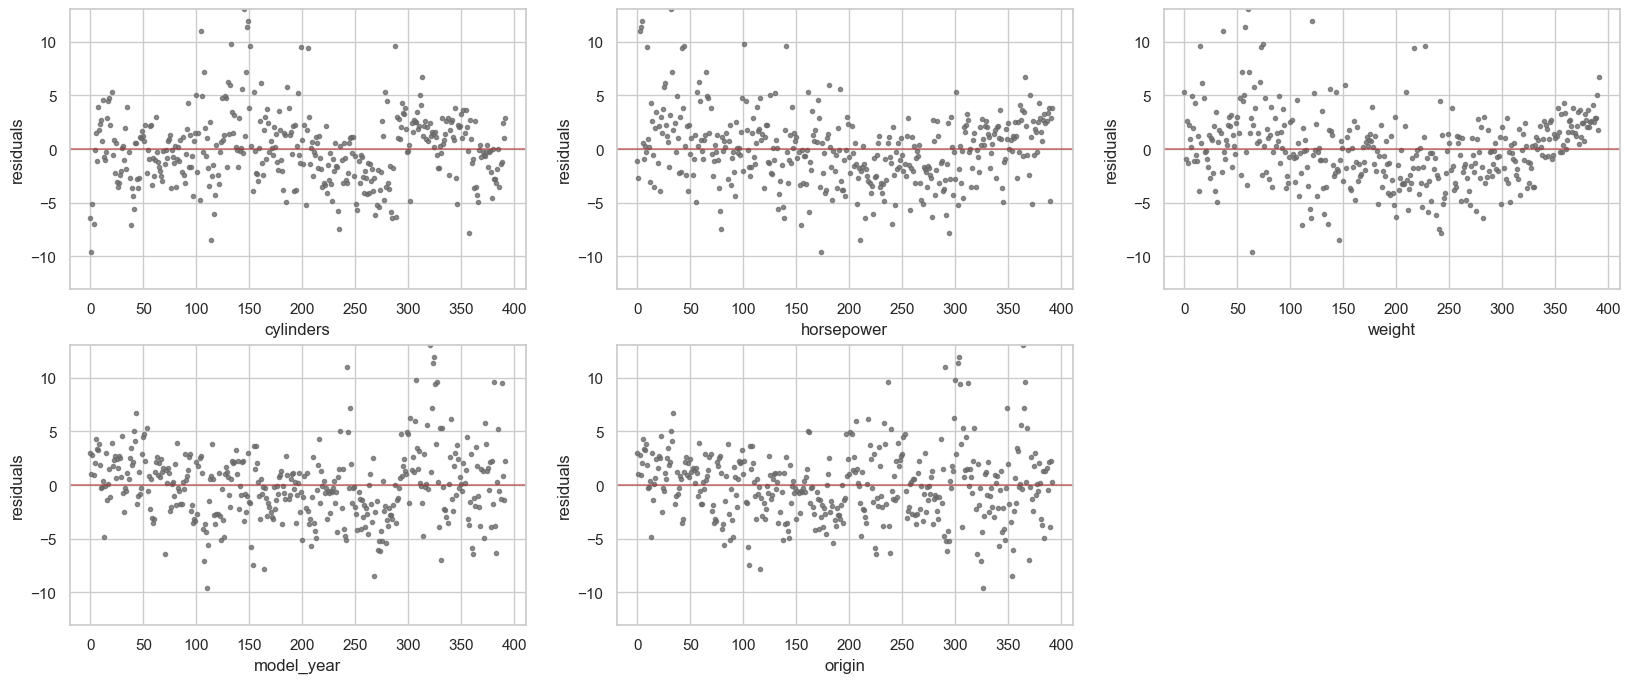

In [190]:
residuals1 = plot_residuals(result1, ["cylinders", "horsepower", "weight", "model_year", "origin"])

For the cylinders, the distribution of the residuals are more centered around 0. They are not symmetrical, but are distribute between -10 to 13. For 'horsepower' and 'weight', there appears to be a curved non-linear distribution. At lower values of 'horsepower' and 'weight' the residual distribution is more spread out, and as you increase the values the distribution gets tighter and curves up. As for 'model_year' and 'origin' the residual distribution is tighter at the lower values, and as you increase the values the distribution spreads out. There appears to be a slight curvature associated as well. 

Let's remove one coefficient, 'displacement', and evaluate if the model gets better:

In [192]:
model = "mpg ~ cylinders + horsepower + weight + acceleration + model_year + origin"
result2 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result2)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-18.091532,-27.722626,-8.319501
cylinders,$\beta_{1}$,0.074628,-0.451738,0.550521
horsepower,$\beta_{2}$,-0.006247,-0.026774,0.018074
weight,$\beta_{3}$,-0.005808,-0.006924,-0.004638
acceleration,$\beta_{4}$,0.053820,-0.180915,0.306727
model_year,$\beta_{5}$,0.741768,0.637489,0.838095
origin,$\beta_{6}$,1.192679,0.629983,1.858387
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


$R^2$ and $\sigma$ stayed relatively the same. Let's look at the residuals:

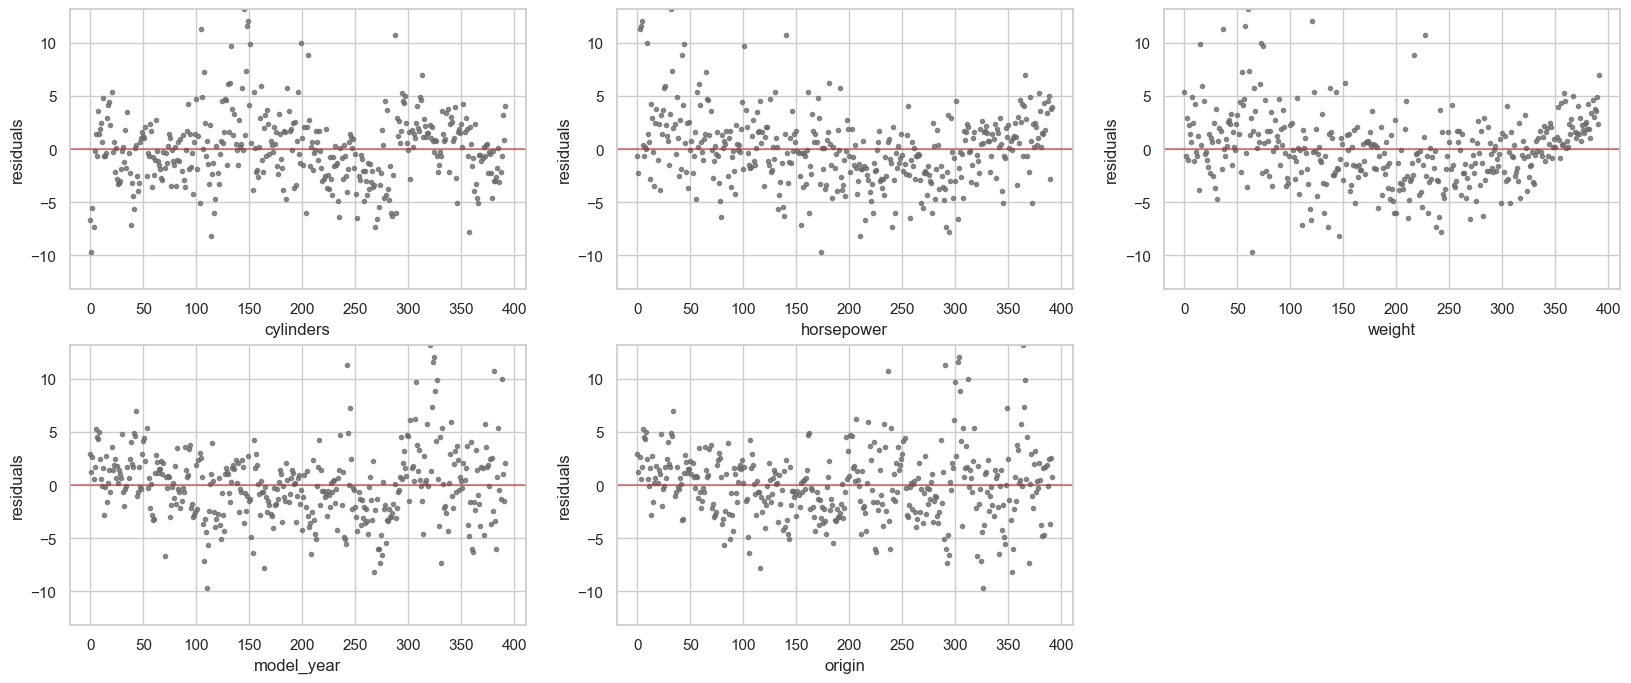

In [194]:
residuals2 = plot_residuals(result2, ["cylinders", "horsepower", "weight", "model_year", "origin"])

The patters of the residuals didn't change. We are still seeing the slight curvatures in 'horsepower', 'weight', 'model_year', and 'origin'. Let's remove 'acceleration' based on the credible intervals and see if that changes the model:

In [196]:
model = "mpg ~ cylinders + horsepower + weight + model_year + origin"
result3 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result3)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-16.955893,-24.668557,-10.938685
cylinders,$\beta_{1}$,0.053574,-0.295113,0.536056
horsepower,$\beta_{2}$,-0.011161,-0.031273,0.006540
weight,$\beta_{3}$,-0.005650,-0.006729,-0.004710
model_year,$\beta_{4}$,0.739761,0.668292,0.835023
origin,$\beta_{5}$,1.199059,0.815601,1.765060
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,3.350486,3.003324,3.630514,


$R^2$ and $\sigma$ are practically the same as before. Let's look at the residuals:

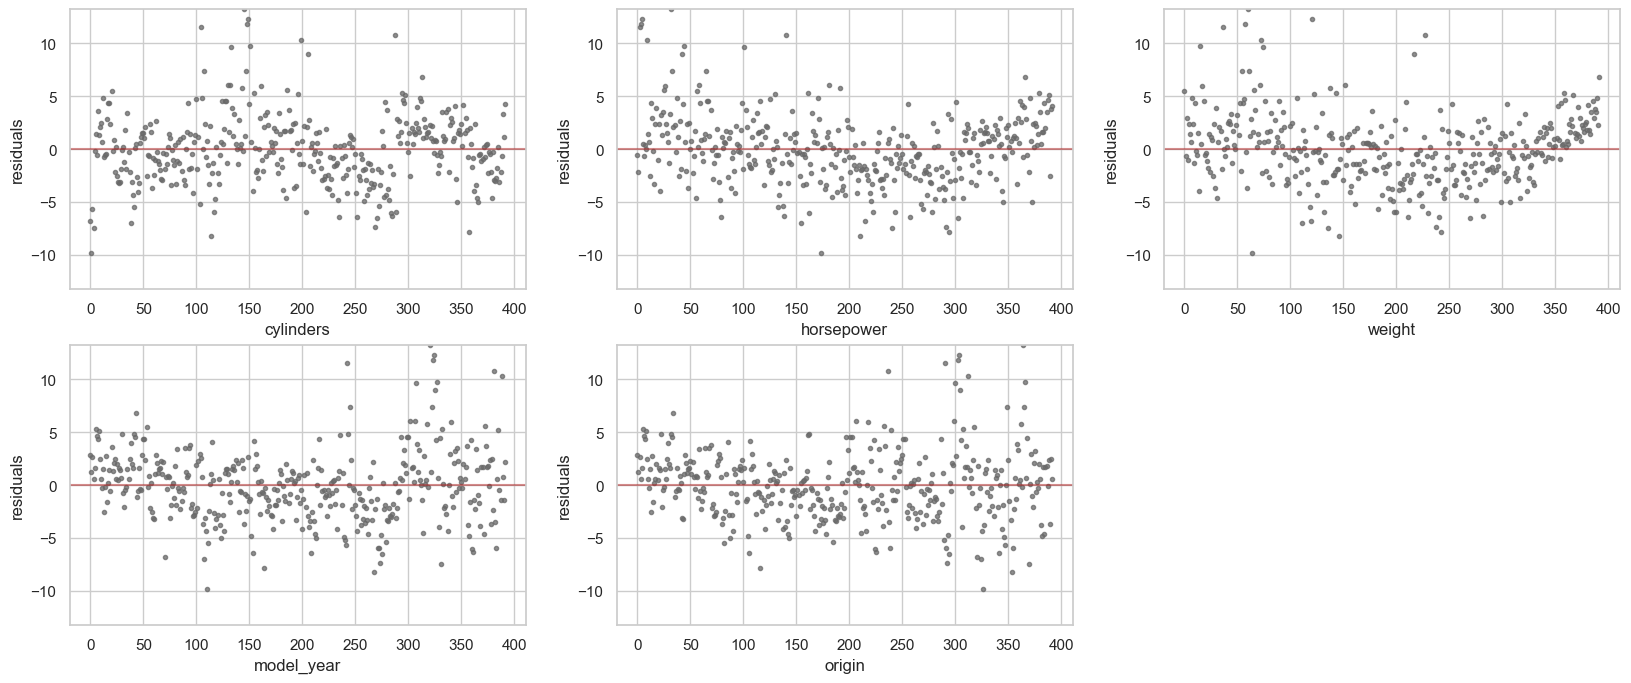

In [198]:
residuals3 = plot_residuals(result3, ["cylinders", "horsepower", "weight", "model_year", "origin"])

The residual distributions stayed the same. There isn't other coefficients to remove or add, so we are now left with transformation and interactive terms. Let's start with squaring the 'model_year'. This would indicate that as you increase 'model_year', 'mpg' also increases at an increasing rate.

In [200]:
df['model_year_sq'] = df.model_year**2

In [201]:
model = "mpg ~ cylinders + horsepower + weight + model_year_sq + origin"
result4 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result4)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,10.829999,7.400305,14.670910
cylinders,$\beta_{1}$,0.058197,-0.386857,0.446281
horsepower,$\beta_{2}$,-0.011748,-0.032167,0.006871
weight,$\beta_{3}$,-0.005618,-0.006588,-0.004684
model_year_sq,$\beta_{4}$,0.004900,0.004197,0.005436
origin,$\beta_{5}$,1.204351,0.797356,1.776109
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,3.334688,2.988536,3.626844,


Squaring the 'model_year' didn't make a big difference. $R^2$ stayed the same, but $\sigma$ went down by 0.02, which isn't much. The effect of 'model_year_sq' is estimated to be 0.0049, which indicates that as you increase or decrease 'model_year_sq', 'mpg' goes up by 0.0049. Let's look at the residuals:

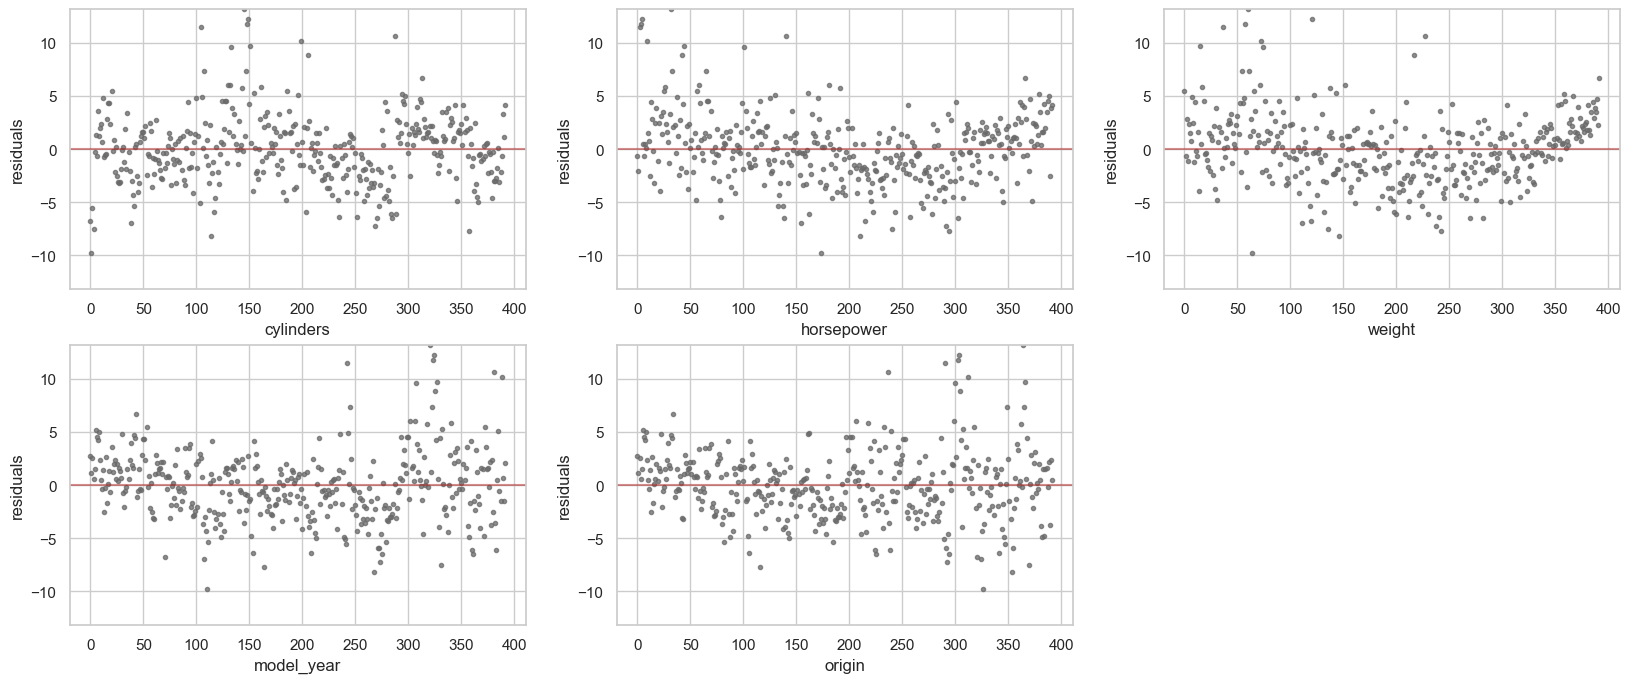

In [203]:
residuals4 = plot_residuals(result4, ["cylinders", "horsepower", "weight", "model_year", "origin"])

The residual distribution patterns didn't change. This indicates that squaring the 'model_year' wasn't beneficial for the model. What if as 'horsepower' goes up, 'mpg' goes down at an increasing rate? Let's square the 'horsepower' and see if that makes a difference on the model:

In [205]:
df['horsepower_sq'] = df.horsepower**2

In [206]:
model = "mpg ~ cylinders + horsepower_sq + weight + model_year + origin"
result5 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result5)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-18.668331,-25.714976,-12.449908
cylinders,$\beta_{1}$,-0.122009,-0.684034,0.411715
horsepower_sq,$\beta_{2}$,0.000053,-0.000009,0.000106
weight,$\beta_{3}$,-0.006287,-0.007225,-0.005216
model_year,$\beta_{4}$,0.778656,0.693151,0.866185
origin,$\beta_{5}$,1.069955,0.619652,1.521907
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,3.344890,2.963180,3.571502,


$R^2$ stayed the same. The effect of 'horsepower_sq' is now estimated to be 0.000053 and the credible intervals does includes 0. The sign of the coefficient changed. According to the Gelman's decision matrix, for an unexpected sign of the coefficient with inclusion of 0, you need to remove the coefficient. Let's look at the residuals:

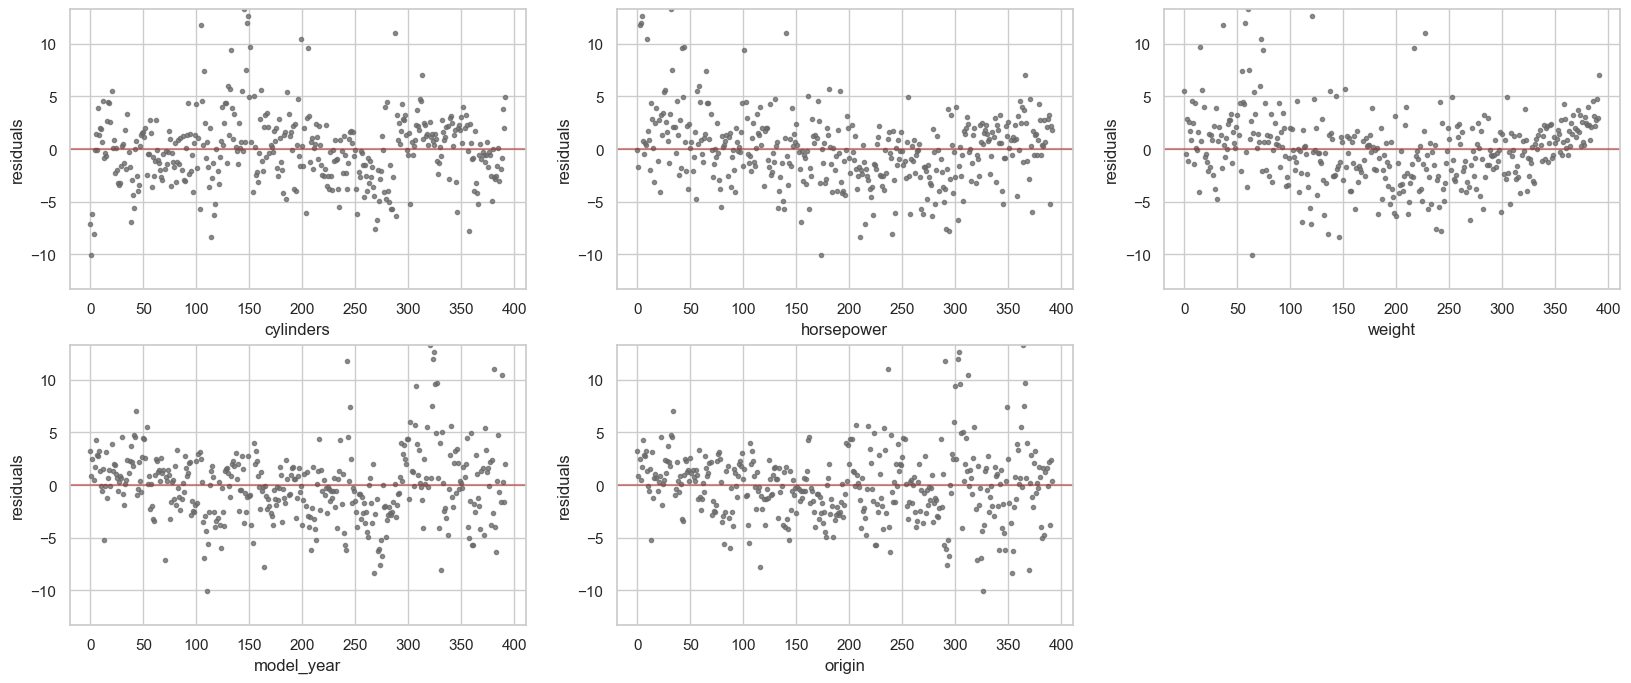

In [208]:
residuals5 = plot_residuals(result5, ["cylinders", "horsepower", "weight", "model_year", "origin"])

That did not change the residual distributions at all, so it confirms there was no increasing rate seen in 'horsepower'. What if there is a decreasing rate to 'horsepower', as 'horsepower' increases 'mpg' decreases at a decreasing rate?

In [210]:
df['horsepower_sqrt'] = df.horsepower.apply(np.sqrt)

In [211]:
model = "mpg ~ cylinders + horsepower_sqrt + weight + model_year + origin"
result6 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result6)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-12.132871,-20.755250,-3.648068
cylinders,$\beta_{1}$,0.174911,-0.327167,0.711869
horsepower_sqrt,$\beta_{2}$,-0.645620,-1.233615,-0.239645
weight,$\beta_{3}$,-0.005112,-0.005928,-0.004057
model_year,$\beta_{4}$,0.715301,0.626364,0.823756
origin,$\beta_{5}$,1.264346,0.798425,1.755048
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,
$\sigma$,3.317269,3.007581,3.594488,


$R^2$ went up ever so slightly to 0.821670 from 0.819792, but $\sigma$ decreased slightly to 3.317269 from 3.334688. Let's look at the residuals:

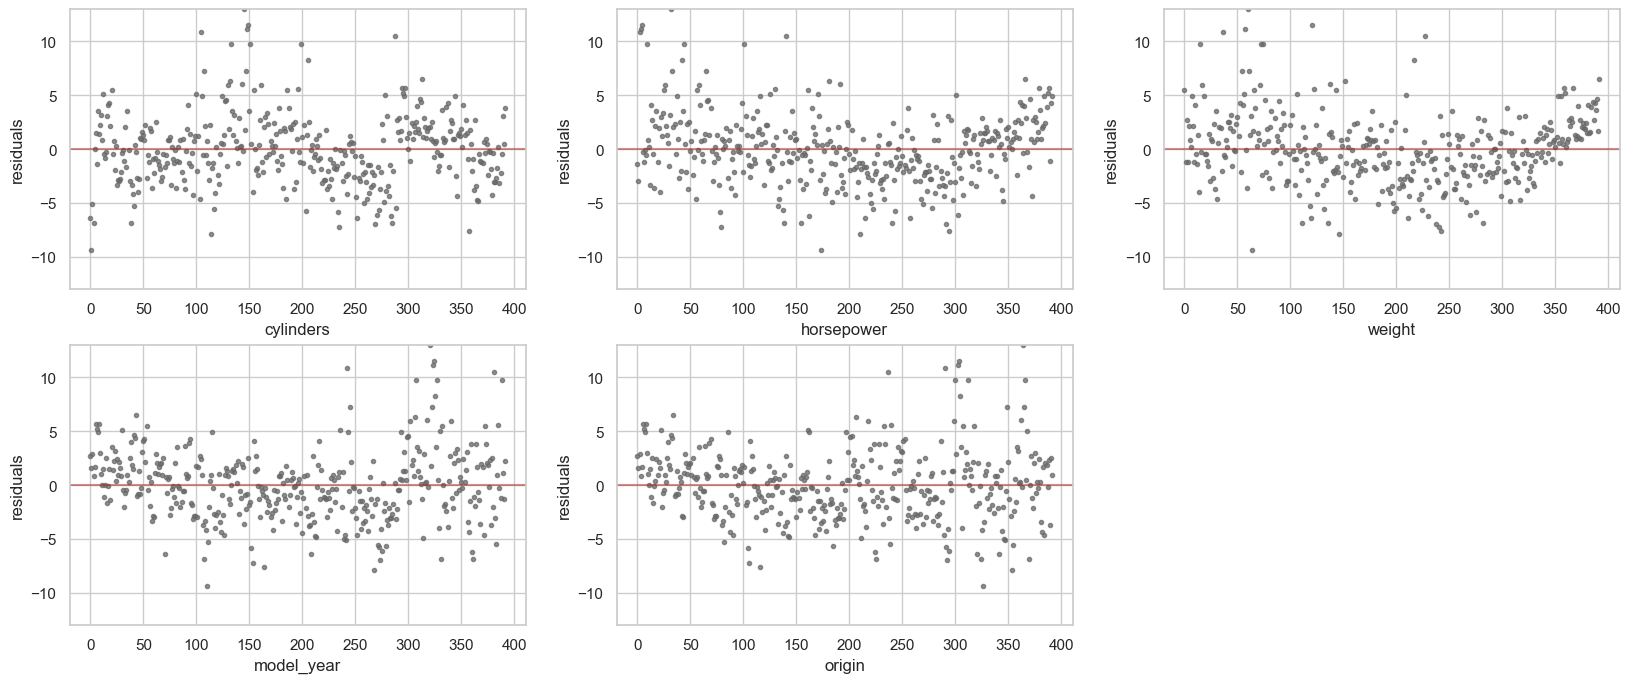

In [213]:
residuals6 = plot_residuals(result6, ["cylinders", "horsepower", "weight", "model_year", "origin"])

The patterns of residual distribution isn't getting better even though the error decreased ever so slightly. Doesn't look like we see the decreasing rate of 'horsepower'. Now let's see if there are any interactive terms between the features. Let's try horsepower and weight:

In [215]:
model = "mpg ~ cylinders + horsepower + weight + horsepower:weight + model_year + origin"
result7 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result7)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,0.528564,-6.807694,10.605323
cylinders,$\beta_{1}$,0.178625,-0.209326,0.515679
horsepower,$\beta_{2}$,-0.218991,-0.260393,-0.167127
weight,$\beta_{3}$,-0.011300,-0.012592,-0.009925
horsepower:weight,$\beta_{4}$,0.000055,0.000044,0.000066
model_year,$\beta_{5}$,0.770405,0.657190,0.850530
origin,$\beta_{6}$,0.753304,0.210728,1.226265
,,,,
Metrics</strong,Mean</strong,Lo</strong,Hi</strong,


The $R^2$ went up a little to 0.86 from 0.82 and $\sigma$ decreased to 2.93 from 3.32. Let's see what happened to the adjusted $R^2$:

In [217]:
print(models.adjusted_r_squared(result1))
print(models.adjusted_r_squared(result7))

0.8172720625761632
0.8581811121049081


The adjusted $R^2$ increased from 0.82 to 0.86. How about the residuals?

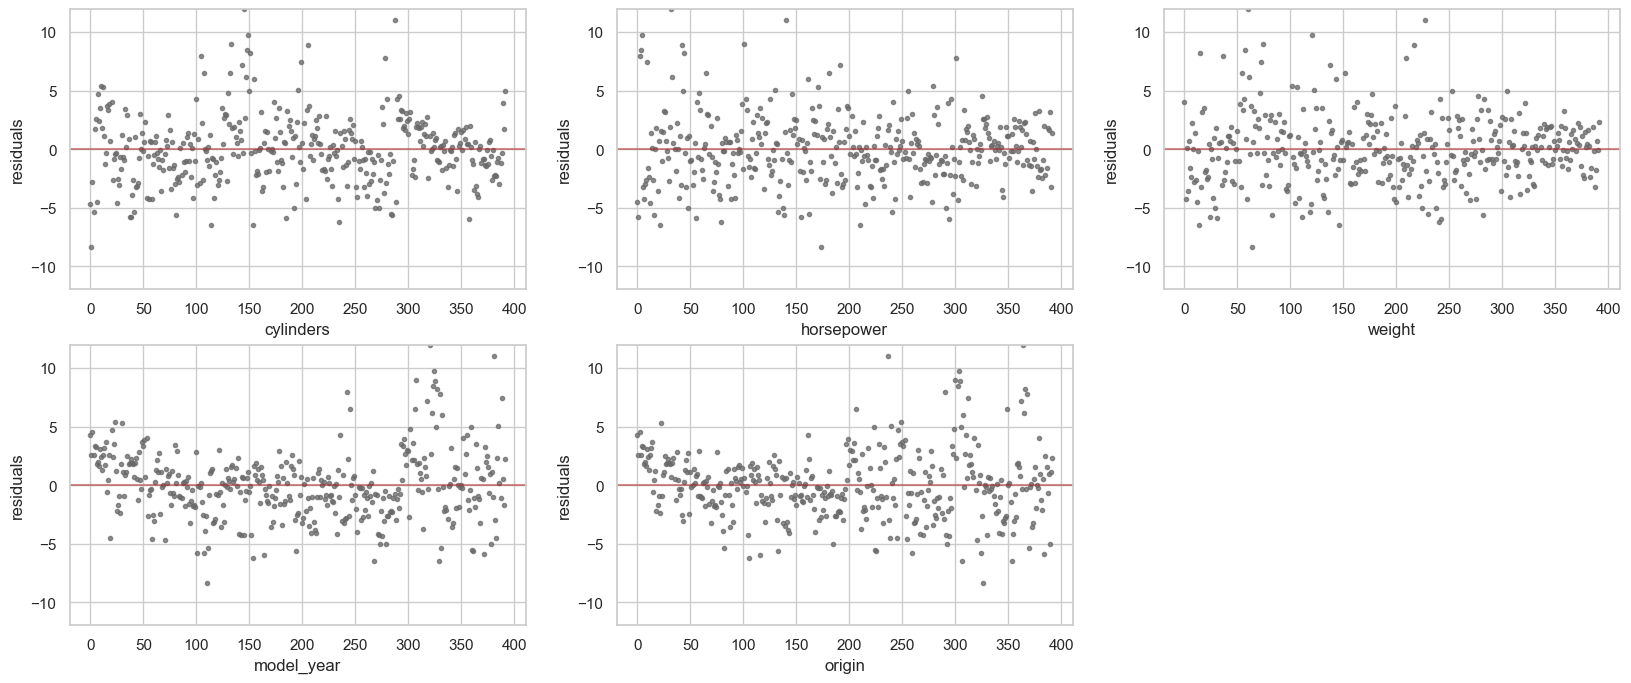

In [219]:
residuals7 = plot_residuals(result7, ["cylinders", "horsepower", "weight", "model_year", "origin"])

The curvatures in 'horsepower' and 'weight' are now gone. I am still seeing the slight curvatures in 'model_year' and 'origin'. Let's see if there is an interaction between 'horsepower' and 'model_year':

In [221]:
model = "mpg ~ cylinders + horsepower + weight + horsepower:weight + model_year + horsepower:model_year + origin"
result8 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result8)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-55.478788,-77.915525,-31.749882
cylinders,$\beta_{1}$,0.271001,-0.109006,0.639824
horsepower,$\beta_{2}$,0.356217,0.183248,0.551792
weight,$\beta_{3}$,-0.009713,-0.010875,-0.008443
horsepower:weight,$\beta_{4}$,0.000042,0.000035,0.000051
model_year,$\beta_{5}$,1.459484,1.140760,1.745768
horsepower:model_year,$\beta_{6}$,-0.007285,-0.010233,-0.004665
origin,$\beta_{7}$,0.801501,0.320833,1.300967
,,,,


This made the model better ever so slightly. $R^2$ is now 0.87 with a smaller $\sigma$ of 2.82. What about the adjusted $R^2$?

In [223]:
print(models.adjusted_r_squared(result1))
print(models.adjusted_r_squared(result8))

0.8172720625761632
0.8687963626045478


Adjusted $R^2$ went from 0.82 to 0.87. Let's look at the residuals:

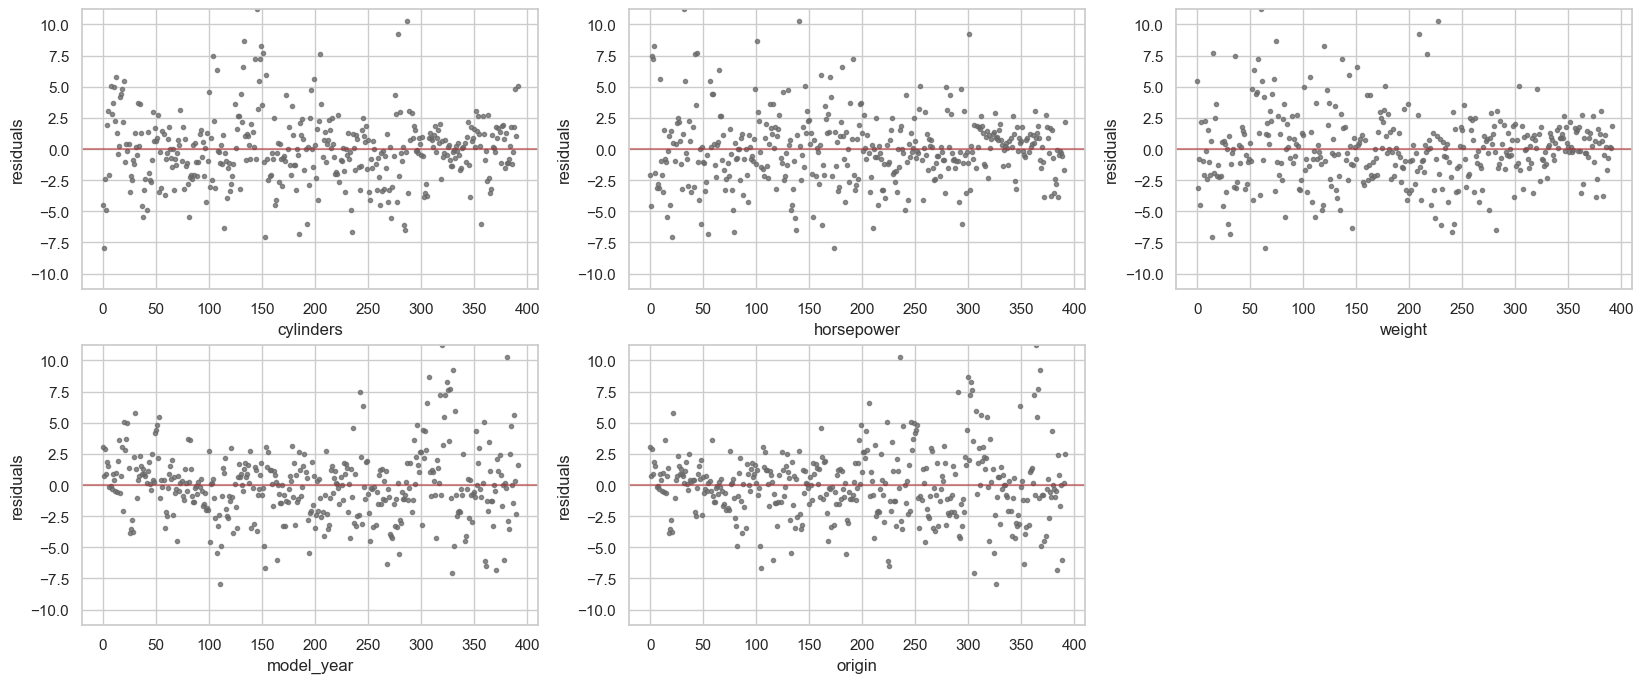

In [225]:
residuals8 = plot_residuals(result8, ["cylinders", "horsepower", "weight", "model_year", "origin"])

'Horsepower' stayed very similar as before, but 'model_year' and 'origin' changed. The distribution of the smaller values of 'model_year' and 'origin' are a little bit wider than before. Now let's see if there is any interaction between 'cylinders' and 'model_year':

In [227]:
model = "mpg ~ cylinders + horsepower + weight + horsepower:weight + model_year + horsepower:model_year + origin + model_year:origin"
result9 = models.bootstrap_linear_regression(model, data=df)
models.describe_bootstrap_lr(result9)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-54.278660,-86.275260,-17.652981
cylinders,$\beta_{1}$,0.266005,-0.088597,0.678541
horsepower,$\beta_{2}$,0.351784,0.095977,0.599189
weight,$\beta_{3}$,-0.009716,-0.010660,-0.008455
horsepower:weight,$\beta_{4}$,0.000042,0.000034,0.000052
model_year,$\beta_{5}$,1.444092,0.965666,1.866870
horsepower:model_year,$\beta_{6}$,-0.007225,-0.010329,-0.003649
origin,$\beta_{7}$,0.351705,-9.509572,8.693742
model_year:origin,$\beta_{8}$,0.005806,-0.106605,0.135854


That didn't change anything. Let's look at the residuals, but I expect there to be no change either:

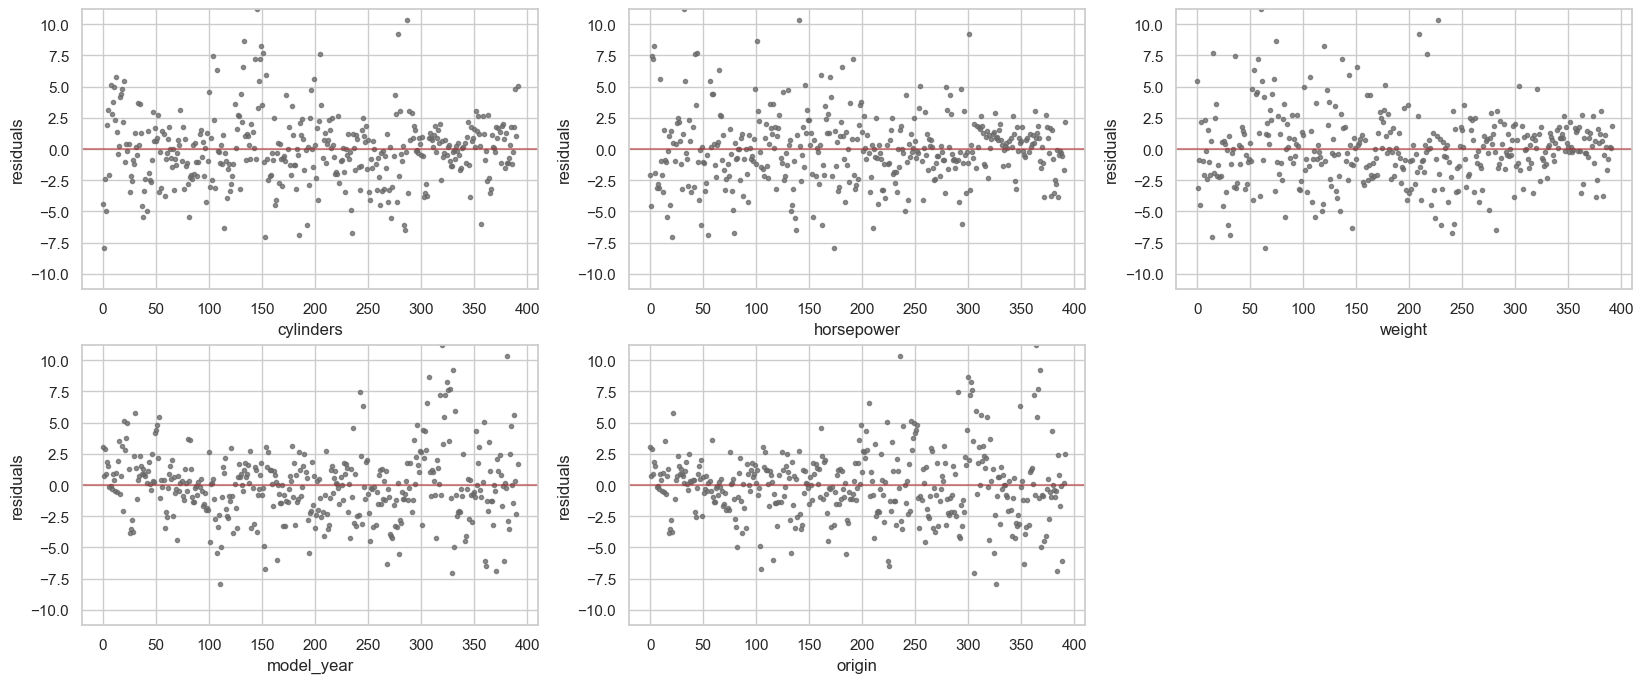

In [229]:
residuals9 = plot_residuals(result9, ["cylinders", "horsepower", "weight", "model_year", "origin"])

As expected, the residual distributions didn't change. This shows that there is no interaction between 'model_year' and 'origin'. I would conclude the final model to be "mpg ~ cylinders + horsepower + weight + horsepower:weight + model_year + horsepower:model_year + origin".

### <a id="step24">Model Evaluation</a>
<a href="#contents">^ Contents</a> 

Let's evaluate the final model by performing three rounds of 10-fold cross validation, estimating $R^2$ and $\sigma$ for each round. Using the results for the test data, I will calculate the 95% Bootstrap estimates of the credible intervals for each.

In [233]:
def chunk(xs, n):
    k, m = divmod(len(xs), n)
    return [xs[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n)]

In [234]:
def cross_validation(algorithm, formula, data, evaluate, fold_count=10, repetitions=3):
    indices = list(range(len( data)))
    metrics = []
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[fold]
            train_indices = [idx not in fold for idx in indices]
            train_data = data.iloc[train_indices]
            result = algorithm(formula, data=train_data)
            model = result["model"]
            y, X = patsy.dmatrices(formula, test_data, return_type="matrix")
            # y = np.ravel( y) # might need for logistic regression
            results = models.summarize(formula, X, y, model)
            metric = evaluate(results)
            metrics.append(metric)
    return metrics

In [235]:
formula = "mpg ~ cylinders + horsepower + weight + horsepower:weight + model_year + horsepower:model_year + origin"
result10 = cross_validation(models.linear_regression, formula, df, lambda r: (r["sigma"], r["r_squared"]))

In [236]:
from tabulate import tabulate

avg_sigma1 = sum(sigma for sigma, _ in result10[:10]) / 10
avg_sigma2 = sum(sigma for sigma, _ in result10[10:20]) / 10
avg_sigma3 = sum(sigma for sigma, _ in result10[20:30]) / 10
avg_r_squared1 = sum(r_squared for _, r_squared in result10[:10]) / 10
avg_r_squared2 = sum(r_squared for _, r_squared in result10[10:20]) / 10
avg_r_squared3 = sum(r_squared for _, r_squared in result10[20:30]) / 10

table = [["Average of 1st Round", avg_sigma1, avg_r_squared1],
        ["Average of 2nd Round", avg_sigma2, avg_r_squared2],
        ["Average of 3rd Round", avg_sigma3, avg_r_squared3]]

print(tabulate(table, headers=["", "Sigma", "R^2"], tablefmt="grid", floatfmt=".4f"))

+----------------------+---------+--------+
|                      |   Sigma |    R^2 |
+======================+=========+========+
| Average of 1st Round |  3.1028 | 0.8681 |
+----------------------+---------+--------+
| Average of 2nd Round |  3.1276 | 0.8647 |
+----------------------+---------+--------+
| Average of 3rd Round |  3.1180 | 0.8663 |
+----------------------+---------+--------+


The table above has the averaged errors ($\sigma$) and $R^2$ for the 3 rounds. We now have enough data of 30 estimates of each metric to estimate the credible bounds. Let's calculate the 95% credible bounds for both the $\sigma$ and $R^2$:

In [238]:
print(r"95% CI for sigma:", stats.mstats.mquantiles([r[0] for r in result10], [0.025, 0.975]))
print(r"95% CI for R^2:", stats.mstats.mquantiles([r[1] for r in result10], [0.025, 0.975]))

95% CI for sigma: [2.27603599 3.79044236]
95% CI for R^2: [0.79308725 0.90612265]


This shows that there is 95% probabiliy that the sigma will be between 2.28 and 3.79 for the results we should expect to see for the new data given the training and test data and priors. Also, there is 95% probability that the $R^2$ will be between 0.79 and 0.91 for the new foreseable data given the training and test data and priors. Let's also calculate the mean of the $\sigma$ and $R^2$ to calculate the 95% credible intervals of the mean values:

In [240]:
sigmas = [r[0] for r in result10]
r_squareds = [r[1] for r in result10]

In [241]:
print("mean sigma: ", np.mean(sigmas))
print("mean R^2: ", np.mean(r_squareds))

mean sigma:  3.116152984712319
mean R^2:  0.8663548110336959


The mean of the $\sigma$ is 3.11 and the mean of $R^2$ is 0.87. Now let's resample the this data to calculate the credible intervals:

In [243]:
def resample(data):
    n = len(data)
    return [data[ i] for i in [stats.randint.rvs(0, n - 1) for _ in range( 0, n)]]

In [244]:
bootstrap = {}
bootstrap["sigma"] = np.array([np.mean(s) for s in [resample(sigmas) for i in range( 0, 1000)]])
bootstrap["r_squared"] = np.array([np.mean(r) for r in [resample(r_squareds) for i in range( 0, 1000)]])

In [245]:
print(r"95% CI for *mean* sigma:", stats.mstats.mquantiles(bootstrap["sigma"], [0.025, 0.975]))
print(r"95% CI for *mean* R^2:", stats.mstats.mquantiles(bootstrap["r_squared"], [0.025, 0.975]))

95% CI for *mean* sigma: [2.98578893 3.23764866]
95% CI for *mean* R^2: [0.85502188 0.8756092 ]


There is 95% probability that the error of the data that we haven't seen yet will be between 2.99 and 3.24 given the data and priors. There is 95% probability that the $R^2$ will be between 0.86 and 0.88 for the new data given the data and priors. Now let's determine if more data will improve the estimation of the model by looking at the learning curves:

### <a id="step25">Learning Curves</a>
<a href="#contents">^ Contents</a> 

In [248]:
from collections import defaultdict

def data_collection():
    result = dict()
    result[ "train"] = defaultdict( list)
    result[ "test"] = defaultdict( list)
    return result

In [249]:
def sse(results):
    errors = results['residuals']
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)

In [250]:
 def learning_curves(algorithm, formula, data, evaluate, fold_count=10, repetitions=3, increment=1):
    indices = list(range(len( data)))
    results = data_collection()
    for _ in range(repetitions):
        random.shuffle(indices)
        folds = chunk(indices, fold_count)
        for fold in folds:
            test_data = data.iloc[ fold]
            train_indices = [idx for idx in indices if idx not in fold]
            train_data = data.iloc[train_indices]
            for i in list(range(increment, 100, increment)) + [100]: # ensures 100% is always picked.
                # the indices are already shuffled so we only need to take ever increasing chunks
                train_chunk_size = int( np.ceil((i/100)*len( train_indices)))
                train_data_chunk = data.iloc[train_indices[0:train_chunk_size]]
                # we calculate the model
                result = algorithm(formula, data=train_data_chunk)
                model = result["model"]
                # we calculate the results for the training data subset
                y, X = patsy.dmatrices( formula, train_data_chunk, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["train"][i].append( metric)
                
                # we calculate the results for the test data.
                y, X = patsy.dmatrices( formula, test_data, return_type="matrix")
                result = models.summarize(formula, X, y, model)
                metric = evaluate(result)
                results["test"][i].append( metric)
            #
        #
    # process results
    # Rely on the CLT...
    statistics = {}
    for k, v in results["train"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["train"] = statistics
    statistics = {}
    for k, v in results["test"].items():
        statistics[ k] = (np.mean(v), np.std(v))
    results["test"] = statistics
    return results

In [251]:
result11 = learning_curves(models.linear_regression, formula, df, lambda r: r["sigma"])

C:\Users\lkim8\Anaconda3\Lib\site-packages\numpy\core\_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [252]:
def results_to_curves( curve, results):
    all_statistics = results[ curve]
    keys = list( all_statistics.keys())
    keys.sort()
    mean = []
    upper = []
    lower = []
    for k in keys:
        m, s = all_statistics[ k]
        mean.append( m)
        upper.append( m + 2 * s)
        lower.append( m - 2 * s)
    return keys, lower, mean, upper

In [253]:
def plot_learning_curves( results, metric, desired=None, zoom=False, credible=True):
    figure = plt.figure(figsize=(10,6))
    axes = figure.add_subplot(1, 1, 1)
    xs, train_lower, train_mean, train_upper = results_to_curves( "train", results)
    _, test_lower, test_mean, test_upper = results_to_curves( "test", results)
    axes.plot( xs, train_mean, color="steelblue", label="train")
    axes.plot( xs, test_mean, color="firebrick", label="test")
    if credible:
        axes.fill_between( xs, train_upper, train_lower, color="steelblue", alpha=0.25)
        axes.fill_between( xs, test_upper, test_lower, color="firebrick", alpha=0.25)
    if desired:
        if type(desired) is tuple:
            axes.axhline((desired[0] + desired[1])/2.0, color="gold", label="desired")
            axes.fill_between( xs, desired[1], desired[0], color="gold", alpha=0.25)
        else:
            axes.axhline( desired, color="gold", label="desired")
    axes.legend()
    axes.set_xlabel( "training set (%)")
    axes.set_ylabel( metric)
    axes.set_title("Learning Curves")
    if zoom:
        y_lower = int( 0.9 * np.amin([train_lower[-1], test_lower[-1]]))
        y_upper = int( 1.1 * np.amax([train_upper[-1], test_upper[-1]]))
        axes.set_ylim((y_lower, y_upper))
    plt.show()
    plt.close()

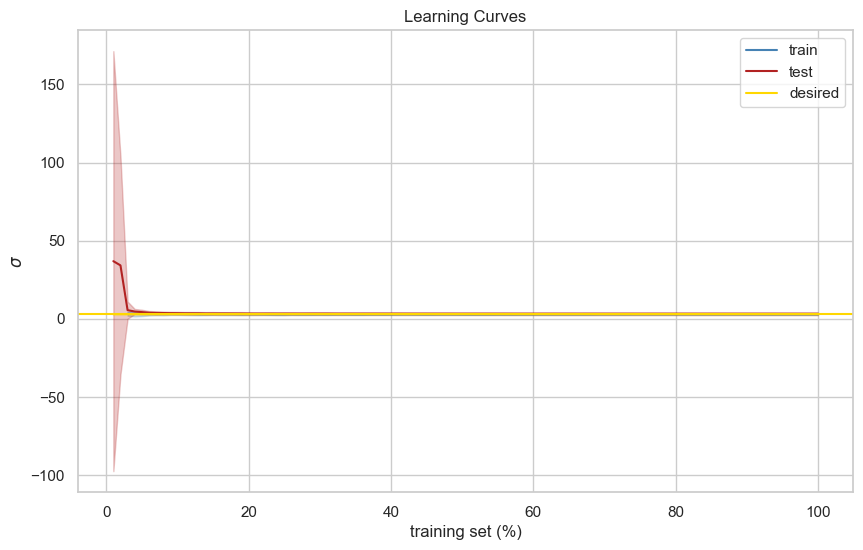

In [254]:
plot_learning_curves(result11, r"$\sigma$", desired=(2.538756, 3.046945))

In this plot you can see that the learning curves quickly converged.. Let's zooom in to see if we can see what's happening a little better:

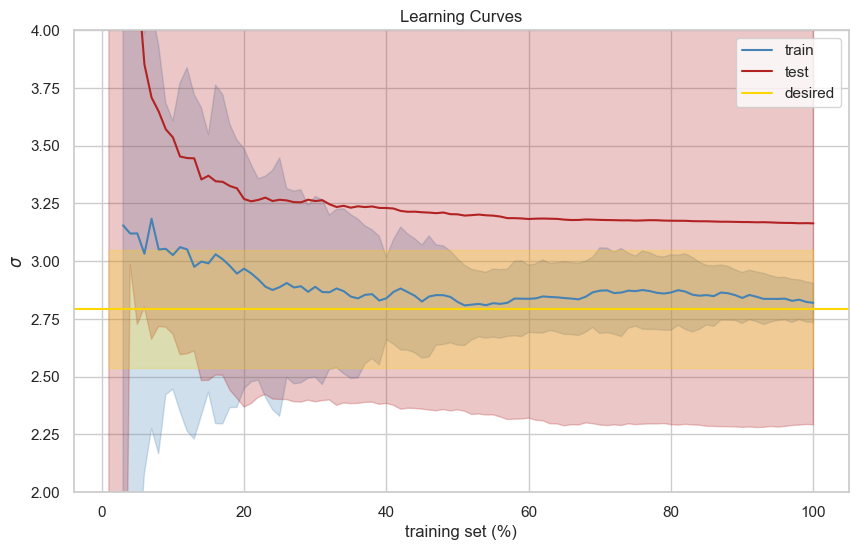

In [256]:
plot_learning_curves(result11, r"$\sigma$", desired=(2.538756, 3.046945), zoom=True)

The learning curves are not too far from each other in the beginning of the training, they are only about 2 $\sigma$ away from each other. The learning curves quickly converge at about 20%. The test curve is above the desired performance while the training curve is nearly at or possibly above the desired performance. This indicates that we have high bias and getting more data will not increase the performance of the model.

We do not have any coefficients with varying parameters for transformations so I will not be doing the validation curve to improve the performance of the model. I also will not be using ridge regression to estimate the model for the auto data since the learning curves showed that we have high bias and when we have high bias, we actually want to reduce the regularization instead of increasing.

## <a id="step26">Final Model</a>
<a href="#contents">^ Contents</a> 

The final model that resulted in the best performance of having the lowest $\sigma$ (error) of the model and the highest $R^2$, which shows the lowest missing values in the model is the model without 'displacement' and 'acceleration' as one of the coefficents and two interactive terms of weight and model_year with horsepower:

In [261]:
models.describe_bootstrap_lr(result8)

,,,95% BCI</strong,
Coefficients</strong,,Mean</strong,Lo</strong,Hi</strong
,$\beta_{0}$,-55.478788,-77.915525,-31.749882
cylinders,$\beta_{1}$,0.271001,-0.109006,0.639824
horsepower,$\beta_{2}$,0.356217,0.183248,0.551792
weight,$\beta_{3}$,-0.009713,-0.010875,-0.008443
horsepower:weight,$\beta_{4}$,0.000042,0.000035,0.000051
model_year,$\beta_{5}$,1.459484,1.140760,1.745768
horsepower:model_year,$\beta_{6}$,-0.007285,-0.010233,-0.004665
origin,$\beta_{7}$,0.801501,0.320833,1.300967
,,,,


In the final model, the `cylinders` coefficient has a mean of 0.27. This states that for every additional cylinder, mpg increases by 0.27. The 95% Bayesian credible interval of (-0.11, 0.64) implies that the effect of cylinders might not be strongly significant. The `horsepower` coefficient has a mean of 0.36 with 95% BCI of (0.18, 0.55). So for every unit increase in horsepower increases mpg by 0.36 units. Since zero isn't included in the credible intervals, it indicates that horsepower appears to have a significant positive effect, in contrary to what is expected (where higher horsepower usually reduces mpg). `Weight` coefficient has a mean of -0.01, which indicates that for every unit increase in weight, it decreases mpg by 0.0097 units. The 95% BCI of (-0.011, -0.008) suggest a negative relationship between weight and mpg. The interactive coefficient of `horsepower and weight`, has a mean of 0.000042. This shows that the effect of horsepower on mpg is slightly dependent on weight. The 95% BCI of (0.000035, 0.000051) shows that the effect is statistically significant, but is small. The `model_year` coefficient has a mean of 1.46. For every additional year in model year, mpg increases by 1.46. The 95% BCI of (1.14, 1.75) confirms that newer cars tend to have better fuel efficiency, likely due to improvements in technology over time. The interactive coefficient between `horsepower and model year` has a mean of -0.0073, which suggests that there is a negative interaction between them. As you increase horsepower, mpg slightly decreases. The 95% BCI of (-0.010, -0.005) supports that this is a significant effect. `Origin` coefficient has a mean of 0.80. This suggest that cars from different origins have an average difference in mpg of 0.80 units. The 95% BCI of (0.32, 1.30) indicates that origin has a significant positive effect on mpg, which means that cars from certain origins are generally more fuel-efficient.

This final model has $R^2$ of 0.87, which went up from the 0.82 where we had all feature coefficients in the linear regression model. The $\sigma$ also reduced to 2.82 from 3.33. The learning curve was used to determine if the model had high bias or high variance. With the low variance of the model and fast convergence of the learning curves, it's been shown that the model as high bias. Getting more data will not increase the performance of the model when high bias is present. There were no coefficients with transformations that improved the performance, so validation curves was not used. Since we have high bias in the data, ridge regression wasn't implemented either.

## <a id="step27">Use The Model</a>
<a href="#contents">^ Contents</a> 

### <a id="step28">Null Model Prediction</a>
<a href="#contents">^ Contents</a> 

Let's use the null model and the final linear regression model to make some predictions. If we look at the null model, we can estimate the mpg to be:

In [266]:
df.mpg.mean()

23.445918367346938

with an error of:

In [268]:
df.mpg.std()

7.8050074865717995

If we get the 95% error bounds for this prediction, it is:

In [270]:
np.percentile(df.mpg, [2.5, 97.5])

array([12.    , 39.0225])

Based on the null model, the predicted mpg is 23.45 mpg with 95% error bounds of 12.00 to 39.02 mpg.

### <a id="step29">Linear Regression Prediction</a>
<a href="#contents">^ Contents</a> 

**(1)** Now suppose we need a prediction for a 1978 car with 6 cylinders, 150 horsepower and 3500 pounds in weight. This feature vector will be:

In [274]:
car = [1.0, 6, 150, 3500, 150*3500, 78, 150*78, 0]

Let's use the Bootstrap to get a distribution of predictions.

In [276]:
predictions = []
for i in range(10_00):
    bootstrap = df.sample(len(df), replace=True, random_state=342234)
    result = models.linear_regression("mpg ~ cylinders + horsepower + weight + horsepower:weight + model_year + horsepower:model_year + origin", data=bootstrap)
    predict = result["model"].predict([[1.0, 6, 150, 3500, 150*3500, 78, 150*78, 0]])[0][0]
    error = random.choice(result["residuals"])[0]
    obs = predict + error
    predictions.append(obs)

Based on our final model, we can predict the following mpg for the 1978 car:

In [278]:
result["model"].predict([[1.0, 6, 150, 3500, 150*3500, 78, 150*78, 0]])[0][0]

16.735552640030335

Our linear regression model predicts mpg of 16.74 mpg for the 1978 car. The distribution of predictions based on the Bootstrap is:

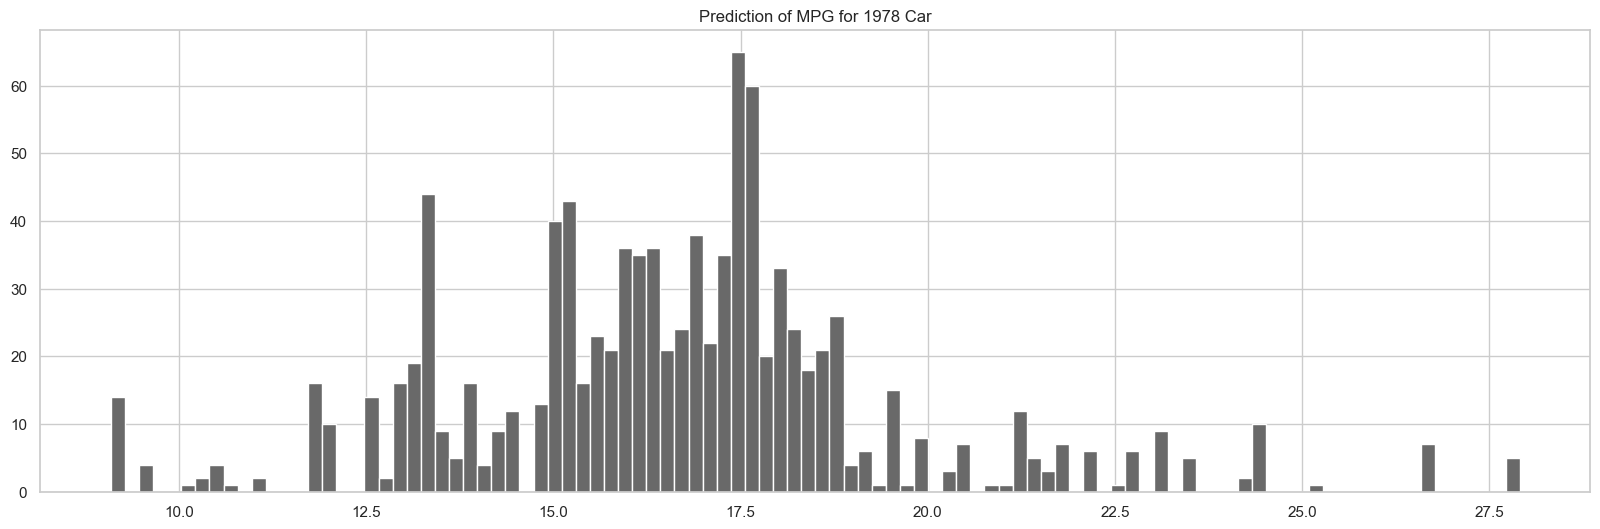

In [280]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(predictions, bins=100, color='dimgray')
axes.set_title("Prediction of MPG for 1978 Car")
plt.show()
plt.close();

Let's calculate the 95% error bounds of the prediction:

In [282]:
np.percentile(predictions, [2.5, 97.5])

array([10.76481285, 23.56458423])

The prediction range using the Bootstrap results is 11.00 to 24.34 mpg. This prediction is narrower than the null model (12.00 to 39.02 mpg). I currently do not know if this narrowing of prediction range is enough. That would depend on the goal of the stakeholder.

**(2)** Let's look at another case where we want to get a prediction for a 1980 car with 4 cylinders, 125 horsepower, and 3000 pounds in weight. This car's vector will be:

In [285]:
car2 = [1.0, 4, 125, 3000, 125*3000, 80, 125*80, 0]

Let's use the Bootstrap to get a distribution of predictions:

In [287]:
predictions2 = []
for i in range(10_00):
    bootstrap = df.sample(len(df), replace=True, random_state=342234)
    result = models.linear_regression("mpg ~ cylinders + horsepower + weight + horsepower:weight + model_year + horsepower:model_year + origin", data=bootstrap)
    predict = result["model"].predict([[1.0, 4, 125, 3000, 125*3000, 80, 125*80, 0]])[0][0]
    error = random.choice(result["residuals"])[0]
    obs = predict + error
    predictions2.append(obs)

In [288]:
result["model"].predict([[1.0, 4, 125, 3000, 125*3000, 80, 125*80, 0]])[0][0]

20.991689830823148

Our linear regression model predicts mpg of 20.99 mpg for the 1980 car. The distribution of predictions based on the Bootstrap is:

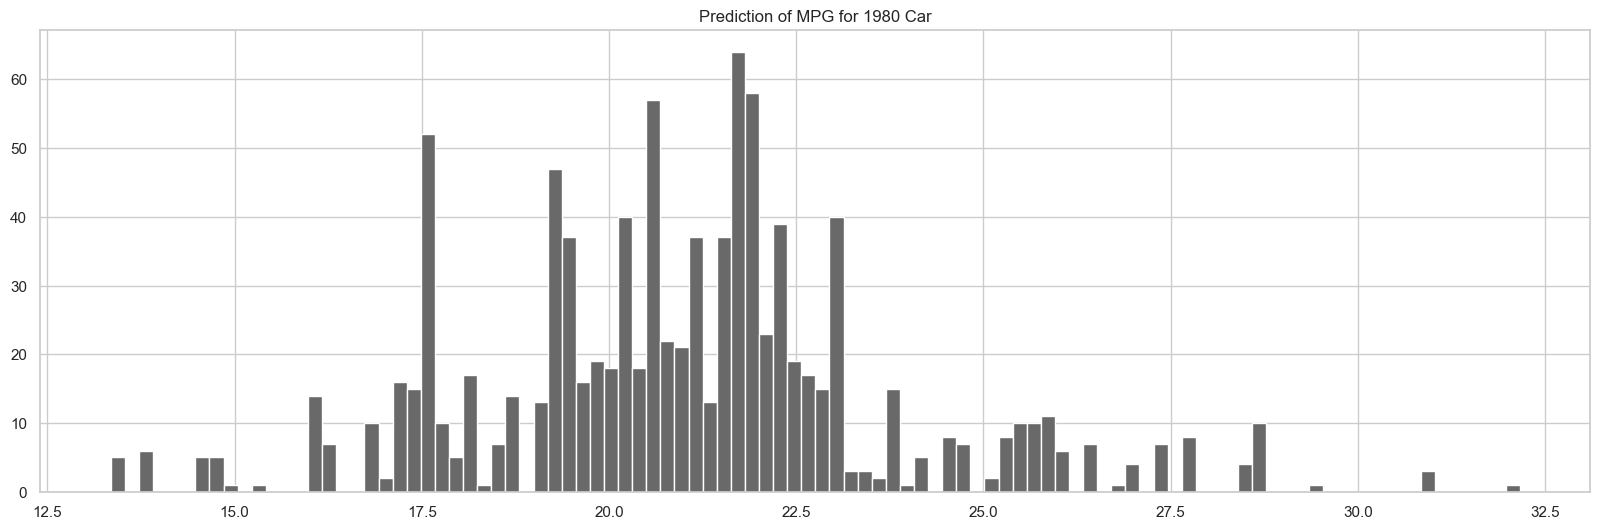

In [290]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(predictions2, bins=100, color='dimgray')
axes.set_title("Prediction of MPG for 1980 Car")
plt.show()
plt.close();

Let's calculate the 95% error bounds of this prediction:

In [292]:
np.percentile(predictions2, [2.5, 97.5])

array([16.11468944, 27.80210623])

The prediction range using the Bootstrap results is 16.09 to 28.60 mpg for the 1980 car. This prediction is narrower than the null model as well. We do not know if this narrowing of this prediction range for this car is enough and it would depend on the stakeholder's goals.

**(3)** Let's look at a third case where we need prediction for a 1975 car with 8 cylinders, 200 horsepower, and 4000 pounds in weight. The vector for this car is:

In [295]:
car3 = [1.0, 8, 200, 4000, 200*4000, 75, 200*75, 0]

Let's use the Bootstrap to get a distribution of predictions:

In [297]:
predictions3 = []
for i in range(10_00):
    bootstrap = df.sample(len(df), replace=True, random_state=342234)
    result = models.linear_regression("mpg ~ cylinders + horsepower + weight + horsepower:weight + model_year + horsepower:model_year + origin", data=bootstrap)
    predict = result["model"].predict([[1.0, 8, 200, 4000, 200*4000, 75, 200*75, 0]])[0][0]
    error = random.choice(result["residuals"])[0]
    obs = predict + error
    predictions3.append(obs)

In [298]:
result["model"].predict([[1.0, 8, 200, 4000, 200*4000, 75, 200*75, 0]])[0][0]

13.933219417438345

Our linear regression model predicts mpg of 13.93 mpg for the 1975 car. The distribution of predictions based on the Bootstrap is:

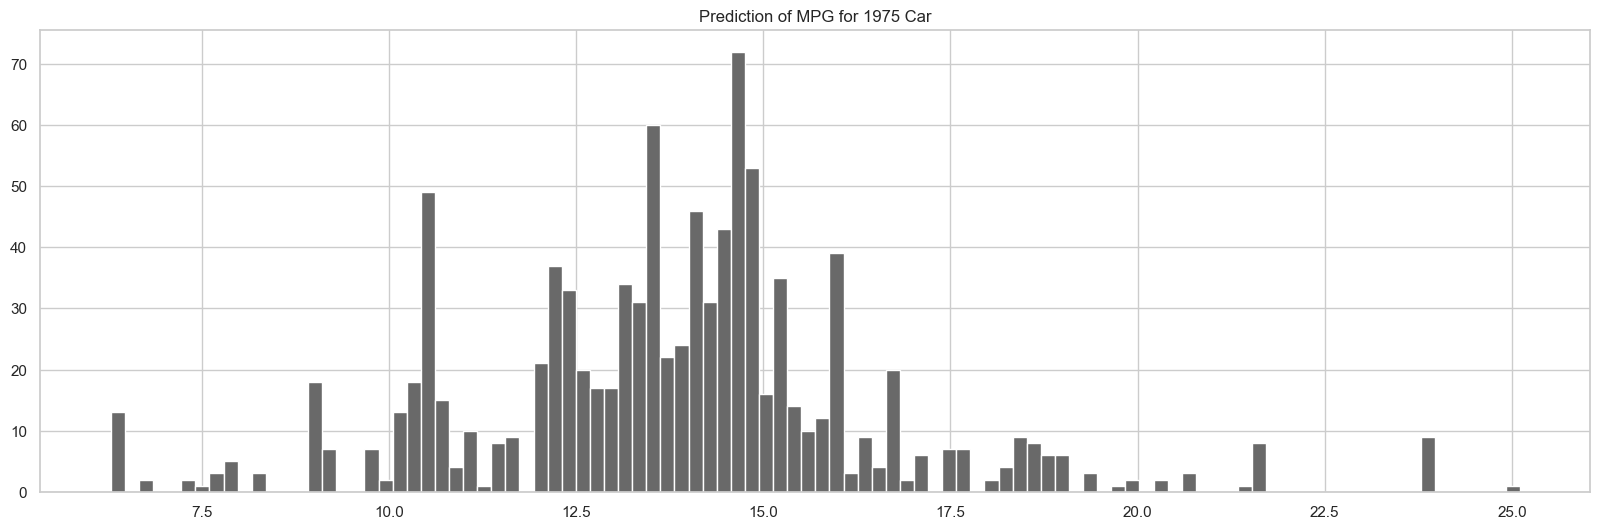

In [300]:
figure = plt.figure(figsize=(20,6))
axes = figure.add_subplot(1,1,1)
axes.hist(predictions3, bins=100, color='dimgray')
axes.set_title("Prediction of MPG for 1975 Car")
plt.show()
plt.close();

Let's calculate the 95% error bounds of this prediction:

In [302]:
np.percentile(predictions3, [2.5, 97.5])

array([ 7.96902514, 19.94150511])

The prediction range using the Bootstrap results is 7.71 to 21.55 mpg for the 1975 car. This prediction is also narrower than the null model (12.00 to 39.02 mpg). Whether this narrowing of the prediction range is acceptable or not will depend on the stakeholder's goal.

## <a id="step30">Conclusion</a>
<a href="#contents">^ Contents</a>

In this analysis of the Auto-MPG dataset, I explored various models to predict fuel efficiency (mpg) and assessed their performance. I applied distributional and linear regression models, drawing comparisons with the baseline null model and refining predictions using more vehicle-specific features.

The null model predicted an average mpg of 23.45, with wide error bounds (12.00 to 39.02 mpg), reflecting significant uncertainty in the estimate without considering vehicle-specific features. In contrast, the distributional model can be used to provide probability-based insights, such as:

There is a 20% probability that a random car will achieve more than 30 mpg.
There is 25% probability that a random car's mpg will be between 20 to 25 mpg.
There is a 19% probability that a random car’s mpg will fall between 15 and 20 mpg.
Cars are likely to achieve 13.5 mpg or lower with a 10% probability.

These predictions offer useful insights for understanding the overall variability of fuel efficiency in the dataset.

With the linear regression model, we refined these predictions by incorporating key features such as cylinders, horsepower, weight, model year, and origin. The inclusion of interactions, such as between horsepower and weight, and between horsepower and model year, added nuance to the model, allowing for more accurate predictions. For example, a 1975 car with 8 cylinders, 200 horsepower, and 4000 pounds in weight is predicted to have an mpg of 13.93. Using bootstrap sampling, the 95% error bounds for this prediction are narrowed to 7.71 to 21.55 mpg, showing a much tighter range compared to the null model. This more specific prediction allows stakeholders to make more informed decisions about fuel efficiency based on the characteristics of individual vehicles. The linear regression model provided robust predictions with a strong $R^2$ of 0.87, indicating that it explains a substantial proportion of the variance in mpg.

The high bias observed in the learning curves suggests that adding more data would not substantially improve the model's performance. Instead, exploring more sophisticated models or feature engineering may provide further improvements. However, the linear regression model with interactions has shown to perform well, explaining a large portion of the variance in mpg and delivering predictions with more precise error bounds.

Ultimately, whether the narrower prediction ranges are acceptable depends on the stakeholder's goals and the level of uncertainty they are willing to tolerate.